# FORECAST

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

from catboost import CatBoostClassifier
from sklearn.multioutput import MultiOutputClassifier

from lightgbm import LGBMClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier

from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from sklearn.utils.class_weight import compute_class_weight

from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

from keras.models import Model
from keras.layers import Input, Dense, Dropout
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

from keras.models import Model
from keras.layers import Input, Dense, Dropout
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score


2025-05-19 04:53:56.699811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747630436.989565      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747630437.079219      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
step = 4  # Horizon (5 bulan) [4,5,6] ##6 paling tinggi
lookback = 12  # Lookback (12 bulan) 
kfold = 5
seed = 42

In [4]:
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=42):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
    os.environ["NUMEXPR_NUM_THREADS"] = "1"

# Call the above function with seed value
set_global_determinism(seed=seed)

In [5]:
# Memeriksa apakah GPU tersedia
print("Is GPU available:", tf.config.list_physical_devices('GPU'))

Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1) LOAD DATA

In [6]:
# Load the data
data = pd.read_excel('/kaggle/input/datagula/22042025 Data Gula (tahun kedua) rev.xlsx', sheet_name=4)
data = data.drop(['No'], axis=1)
data

,Province,Year,Month,Production,Importation,Demand,Supply,Price,Jumlah Penduduk,HBKN,Latitude,Longitude,Economy Growth (%)
0,Aceh,2013,1,0.0,0.0,3262.0,0.0,12500.0,4811100,0,4.695135,96.749399,NaN
1,Aceh,2013,2,0.0,0.0,3127.0,0.0,12500.0,4811100,0,4.695135,96.749399,NaN
2,Aceh,2013,3,0.0,0.0,3223.0,0.0,12500.0,4811100,0,4.695135,96.749399,NaN
3,Aceh,2013,4,0.0,0.0,4188.0,0.0,12000.0,4811100,0,4.695135,96.749399,NaN
4,Aceh,2013,5,0.0,0.0,5076.0,0.0,12659.0,4811100,0,4.695135,96.749399,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075,Papua,2022,8,0.0,0.0,2460.0,0.0,16120.0,4418600,0,4.269928,138.080353,8.97
4076,Papua,2022,9,0.0,0.0,5308.0,0.0,15846.0,4418600,0,4.269928,138.080353,8.97
4077,Papua,2022,10,0.0,0.0,2538.0,0.0,15425.0,4418600,0,4.269928,138.080353,8.97
4078,Papua,2022,11,0.0,0.0,4808.0,0.0,16357.0,4418600,0,4.269928,138.080353,8.97


In [7]:
data['Province'].nunique()

34

## 2) ISI NILAI NAN DENGAN KNN - IMPUTER

In [8]:
data.replace([np.inf, -np.inf], np.nan)
nan_percentage = data.isna().mean() * 100
print(nan_percentage)

Province               0.00000
Year                   0.00000
Month                  0.00000
Production             0.02451
Importation            0.00000
Demand                 0.02451
Supply                 0.02451
Price                  0.02451
Jumlah Penduduk        0.00000
HBKN                   0.00000
Latitude               0.00000
Longitude              0.00000
Economy Growth (%)    30.00000
dtype: float64


In [9]:
# Ambil hanya kolom numerik
numeric_cols = data.select_dtypes(include=[np.number]).columns

# Inisialisasi dan terapkan KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(knn_imputer.fit_transform(data[numeric_cols]), columns=numeric_cols)

# Gantikan kolom numerik asli dengan hasil imputasi
data[numeric_cols] = data_imputed

# Tampilkan data setelah imputasi
data

,Province,Year,Month,Production,Importation,Demand,Supply,Price,Jumlah Penduduk,HBKN,Latitude,Longitude,Economy Growth (%)
0,Aceh,2013.0,1.0,0.0,0.0,3262.0,0.0,12500.0,4811100.0,0.0,4.695135,96.749399,4.140
1,Aceh,2013.0,2.0,0.0,0.0,3127.0,0.0,12500.0,4811100.0,0.0,4.695135,96.749399,4.140
2,Aceh,2013.0,3.0,0.0,0.0,3223.0,0.0,12500.0,4811100.0,0.0,4.695135,96.749399,4.140
3,Aceh,2013.0,4.0,0.0,0.0,4188.0,0.0,12000.0,4811100.0,0.0,4.695135,96.749399,3.608
4,Aceh,2013.0,5.0,0.0,0.0,5076.0,0.0,12659.0,4811100.0,0.0,4.695135,96.749399,3.342
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075,Papua,2022.0,8.0,0.0,0.0,2460.0,0.0,16120.0,4418600.0,0.0,4.269928,138.080353,8.970
4076,Papua,2022.0,9.0,0.0,0.0,5308.0,0.0,15846.0,4418600.0,0.0,4.269928,138.080353,8.970
4077,Papua,2022.0,10.0,0.0,0.0,2538.0,0.0,15425.0,4418600.0,0.0,4.269928,138.080353,8.970
4078,Papua,2022.0,11.0,0.0,0.0,4808.0,0.0,16357.0,4418600.0,0.0,4.269928,138.080353,8.970


In [10]:
nan_percentage = data.isna().mean() * 100
print(nan_percentage)

Province              0.0
Year                  0.0
Month                 0.0
Production            0.0
Importation           0.0
Demand                0.0
Supply                0.0
Price                 0.0
Jumlah Penduduk       0.0
HBKN                  0.0
Latitude              0.0
Longitude             0.0
Economy Growth (%)    0.0
dtype: float64


In [11]:
data

,Province,Year,Month,Production,Importation,Demand,Supply,Price,Jumlah Penduduk,HBKN,Latitude,Longitude,Economy Growth (%)
0,Aceh,2013.0,1.0,0.0,0.0,3262.0,0.0,12500.0,4811100.0,0.0,4.695135,96.749399,4.140
1,Aceh,2013.0,2.0,0.0,0.0,3127.0,0.0,12500.0,4811100.0,0.0,4.695135,96.749399,4.140
2,Aceh,2013.0,3.0,0.0,0.0,3223.0,0.0,12500.0,4811100.0,0.0,4.695135,96.749399,4.140
3,Aceh,2013.0,4.0,0.0,0.0,4188.0,0.0,12000.0,4811100.0,0.0,4.695135,96.749399,3.608
4,Aceh,2013.0,5.0,0.0,0.0,5076.0,0.0,12659.0,4811100.0,0.0,4.695135,96.749399,3.342
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075,Papua,2022.0,8.0,0.0,0.0,2460.0,0.0,16120.0,4418600.0,0.0,4.269928,138.080353,8.970
4076,Papua,2022.0,9.0,0.0,0.0,5308.0,0.0,15846.0,4418600.0,0.0,4.269928,138.080353,8.970
4077,Papua,2022.0,10.0,0.0,0.0,2538.0,0.0,15425.0,4418600.0,0.0,4.269928,138.080353,8.970
4078,Papua,2022.0,11.0,0.0,0.0,4808.0,0.0,16357.0,4418600.0,0.0,4.269928,138.080353,8.970


## 3) PEMBUATAN LABEL LATE vs NOT LATE

In [12]:
data['Target'] = (data['Demand'] >= data['Supply']).astype(int)
data

,Province,Year,Month,Production,Importation,Demand,Supply,Price,Jumlah Penduduk,HBKN,Latitude,Longitude,Economy Growth (%),Target
0,Aceh,2013.0,1.0,0.0,0.0,3262.0,0.0,12500.0,4811100.0,0.0,4.695135,96.749399,4.140,1
1,Aceh,2013.0,2.0,0.0,0.0,3127.0,0.0,12500.0,4811100.0,0.0,4.695135,96.749399,4.140,1
2,Aceh,2013.0,3.0,0.0,0.0,3223.0,0.0,12500.0,4811100.0,0.0,4.695135,96.749399,4.140,1
3,Aceh,2013.0,4.0,0.0,0.0,4188.0,0.0,12000.0,4811100.0,0.0,4.695135,96.749399,3.608,1
4,Aceh,2013.0,5.0,0.0,0.0,5076.0,0.0,12659.0,4811100.0,0.0,4.695135,96.749399,3.342,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075,Papua,2022.0,8.0,0.0,0.0,2460.0,0.0,16120.0,4418600.0,0.0,4.269928,138.080353,8.970,1
4076,Papua,2022.0,9.0,0.0,0.0,5308.0,0.0,15846.0,4418600.0,0.0,4.269928,138.080353,8.970,1
4077,Papua,2022.0,10.0,0.0,0.0,2538.0,0.0,15425.0,4418600.0,0.0,4.269928,138.080353,8.970,1
4078,Papua,2022.0,11.0,0.0,0.0,4808.0,0.0,16357.0,4418600.0,0.0,4.269928,138.080353,8.970,1


In [13]:
# from sklearn.preprocessing import StandardScaler

# # Salin data agar tidak merusak data asli
# data_copy = data.copy()

# # Tentukan kolom yang tidak ingin dinormalisasi
# excluded_cols = ['Province', 'Year', 'Month','Target']

# # Pilih kolom yang ingin dinormalisasi
# cols_to_scale = [col for col in data.columns if col not in excluded_cols]

# # Buat objek StandardScaler
# scaler = StandardScaler()

# # Fit dan transform kolom yang dipilih saja
# data_copy[cols_to_scale] = scaler.fit_transform(data_copy[cols_to_scale])

# # Hasil
# data_copy


# EXPLORATORY DATA ANALYSIS 

## 1) STATISTIK DESKRIPTIF

In [14]:
data.describe()

,Year,Month,Production,Importation,Demand,Supply,Price,Jumlah Penduduk,HBKN,Latitude,Longitude,Economy Growth (%),Target
count,4080.000000,4080.000000,4080.000000,4080.000000,4080.000000,4080.000000,4080.000000,4.080000e+03,4080.000000,4080.000000,4080.000000,4080.000000,4080.000000
mean,2017.500000,6.500000,5737.199069,46.193696,6373.774559,5783.392765,12978.193284,7.679341e+06,0.164951,3.772017,112.894197,4.376622,0.914216
std,2.872633,3.452476,28508.230330,224.906234,9983.219704,28546.515034,2027.633248,1.072332e+07,0.371182,2.597456,13.700480,3.412889,0.280080
min,2013.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-15.740000,0.000000
25%,2015.000000,3.750000,0.000000,0.000000,1484.000000,0.000000,12000.000000,1.973000e+06,0.000000,1.570999,106.064018,3.341500,1.000000
50%,2017.500000,6.500000,0.000000,0.000000,3052.000000,0.000000,12951.000000,4.245300e+06,0.000000,3.278950,112.238402,4.985000,1.000000
75%,2020.000000,9.250000,0.000000,0.000000,5995.500000,0.001000,14000.000000,7.941500e+06,0.000000,6.194400,121.079370,5.690000,1.000000
max,2022.000000,12.000000,398240.000000,3736.618000,77488.000000,399076.325000,22000.000000,4.737940e+07,1.000000,8.657382,138.080353,22.940000,1.000000


## 2) VIF

In [15]:
numerical_cols = [
    'Production', 'Importation', 'Demand', 'Supply',
    'Price', 'Jumlah Penduduk', 'HBKN', 'Economy Growth (%)'
]

In [16]:
# Misal df adalah dataframe kamu
df_vif = data[numerical_cols] 

X = add_constant(df_vif)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


              Feature        VIF
0               const  46.146009
1          Production        inf
2         Importation        inf
3              Demand   5.530160
4              Supply        inf
5               Price   1.018833
6     Jumlah Penduduk   5.601001
7                HBKN   1.012485
8  Economy Growth (%)   1.007047


## 3) FEATURE CORRELATION

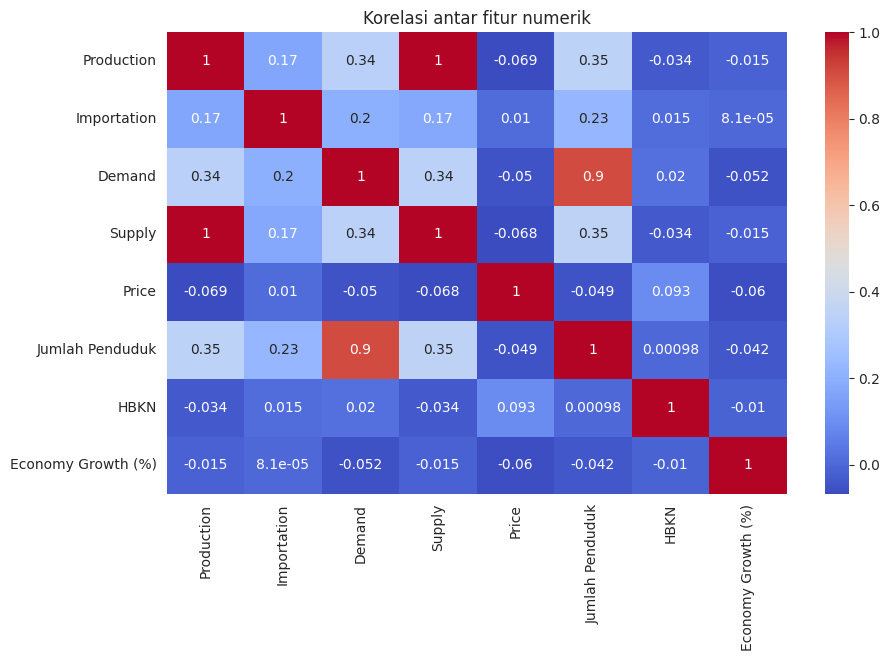

In [17]:
plt.figure(figsize=(10,6))
sns.heatmap(data[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi antar fitur numerik")
plt.show()


## 4) PAIR PLOT

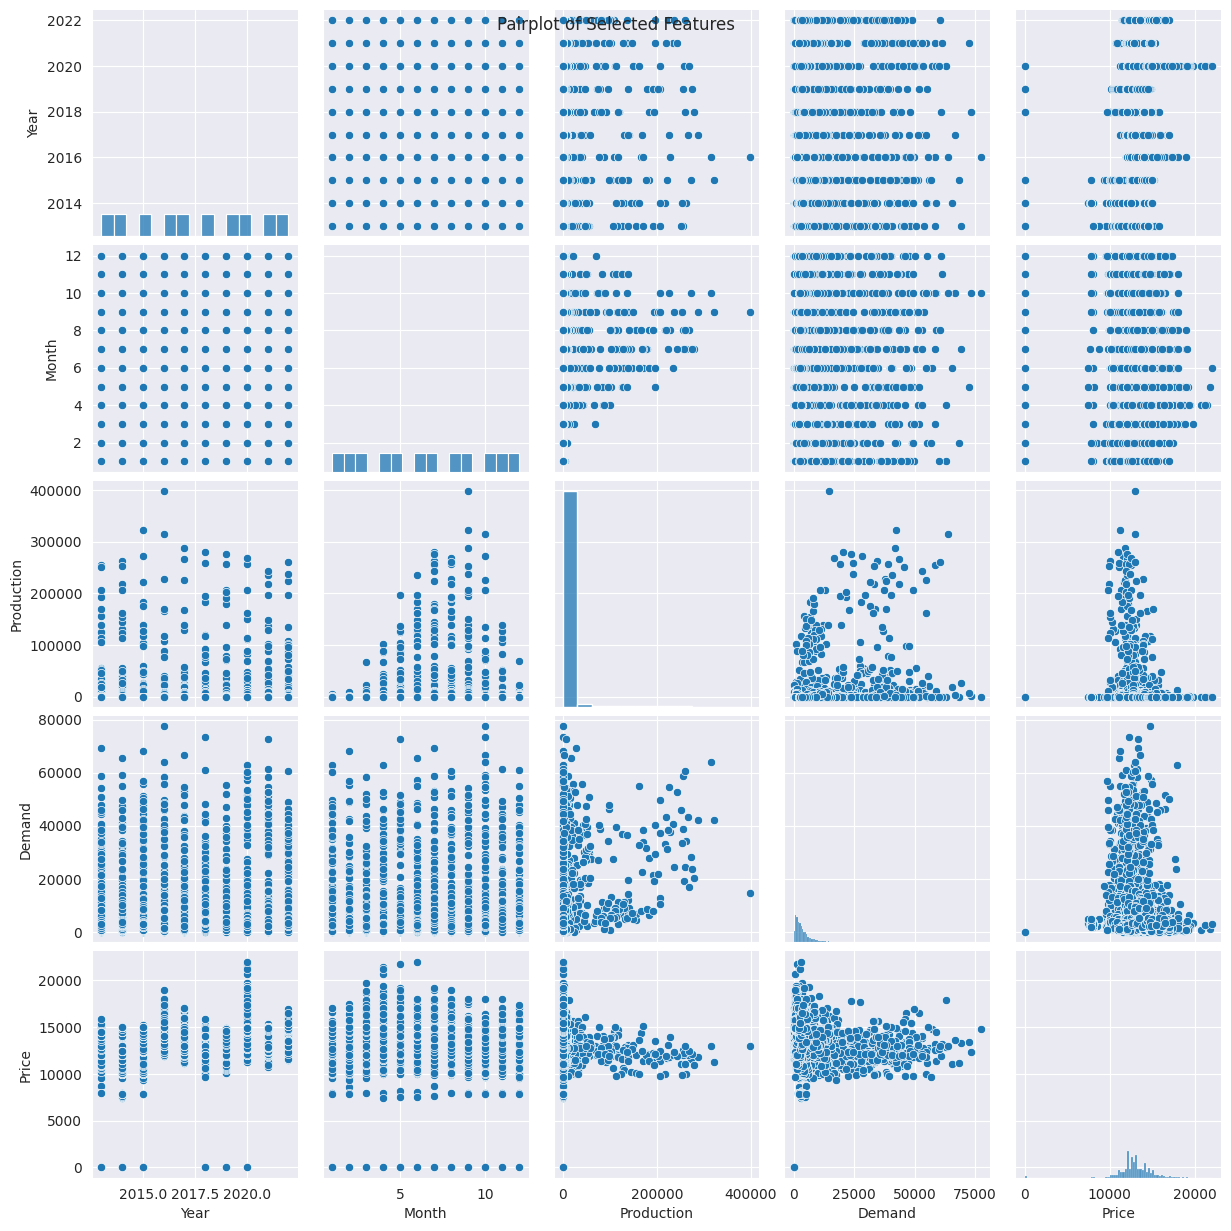

In [18]:
sns.pairplot(data[['Year', 'Month', 'Production', 'Demand', 'Price']])
plt.suptitle('Pairplot of Selected Features')
plt.show()

## 5) LINE PLOT SUPPLY VS DEMAND

In [19]:
data['Year'].value_counts()

Year
2013.0    408
2014.0    408
2015.0    408
2016.0    408
2017.0    408
2018.0    408
2019.0    408
2020.0    408
2021.0    408
2022.0    408
Name: count, dtype: int64

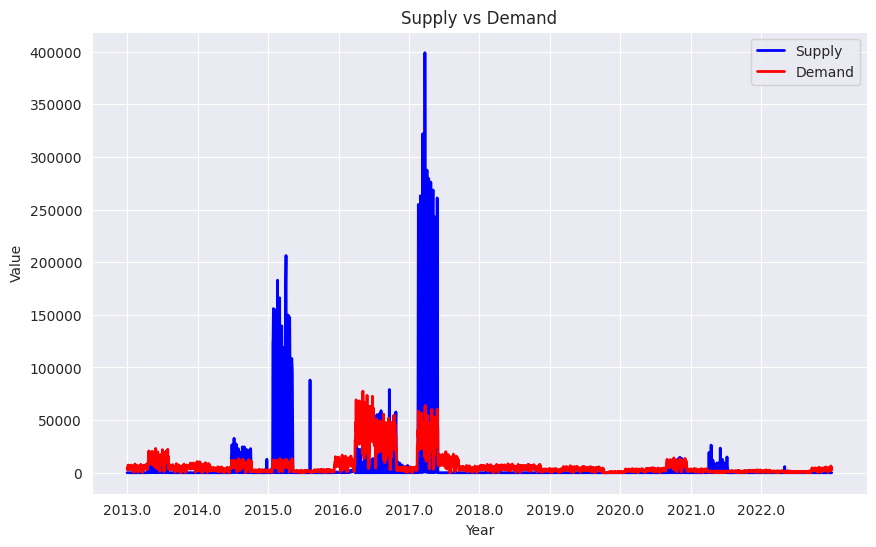

In [20]:
# Asumsikan data adalah DataFrame Anda yang berisi kolom 'Year', 'Supply', dan 'Demand'

# Membuat line plot untuk Supply dan Demand
plt.figure(figsize=(10, 6))

# Plot Supply
plt.plot(data['Supply'], label='Supply', color='blue', linewidth=2)

# Plot Demand
plt.plot(data['Demand'], label='Demand', color='red', linewidth=2)

# Menambahkan title dan labels
plt.title('Supply vs Demand')
plt.xlabel('Year')
plt.ylabel('Value')

# Menentukan posisi xticks berdasarkan tahun yang ingin ditampilkan
year_labels = data['Year'].unique()  # Ambil nilai tahun yang unik dari data
xticks_positions = range(0, len(data), 408)  # Setiap 408 baris

# Menambahkan xticks dengan tahun yang sesuai
plt.xticks(xticks_positions, year_labels)

# Menambahkan legend
plt.legend()

# Menampilkan plot
plt.grid(True)
plt.show()


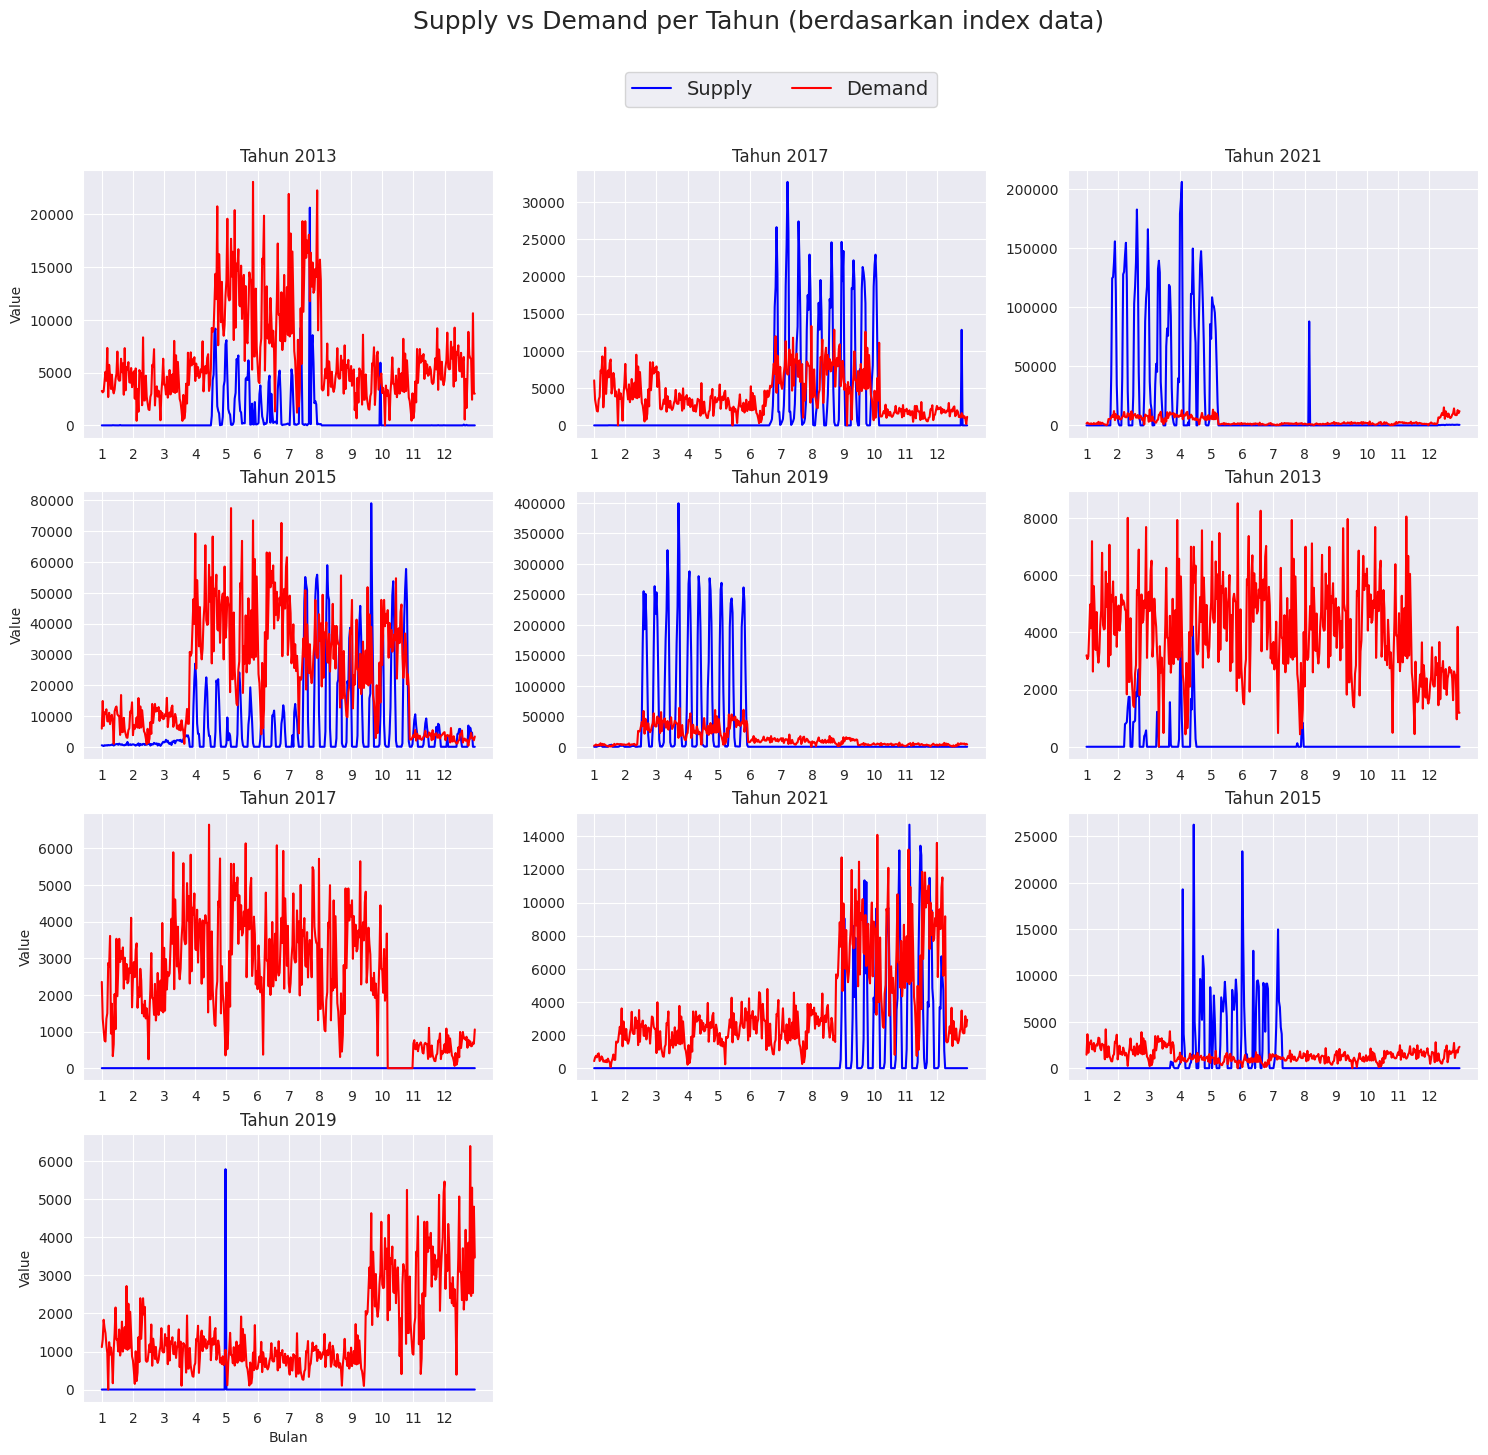

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16))

# Jumlah baris per tahun
rows_per_year = 408

# Jumlah tahun berdasarkan data
num_years = data['Year'].nunique()

for i in range(num_years):
    start_idx = i * rows_per_year
    end_idx = start_idx + rows_per_year

    # Cek agar tidak lewat dari batas data
    if end_idx > len(data):
        break

    plt.subplot(4, 3, i + 1)
    plt.plot(data['Supply'][start_idx:end_idx].values, label='Supply', color='blue')
    plt.plot(data['Demand'][start_idx:end_idx].values, label='Demand', color='red')
    
    year_label = int(data['Year'].iloc[start_idx])
    plt.title(f"Tahun {year_label}")
    plt.grid(True)
    
    # Label X sebagai bulan (karena 408 baris = 12 bulan * 34 provinsi)
    plt.xticks(
        ticks=[i * 34 for i in range(12)],
        labels=[f"{i+1}" for i in range(12)]
    )

    if i % 3 == 0:
        plt.ylabel("Value")
    if i >= 9:
        plt.xlabel("Bulan")

# Tambahkan judul utama
plt.suptitle("Supply vs Demand per Tahun (berdasarkan index data)", fontsize=18, y=0.98)

# Tambahkan legend global di bawah judul
plt.legend(['Supply', 'Demand'], loc='upper center', bbox_to_anchor=(1.7, 5.0), ncol=2, fontsize=14)

# Sesuaikan layout
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


## 6) DISTRIBUTION OF CLASS

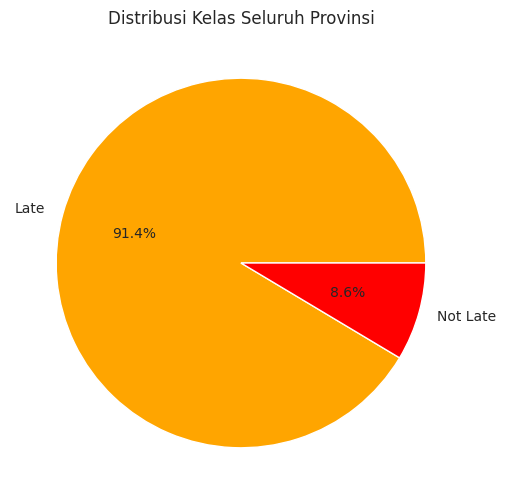

In [22]:
# Menghitung distribusi kelas dari Target
label_counts = data['Target'].value_counts()

# Menentukan label yang sesuai
label_names = {0: 'Not Late', 1: 'Late'}

# Mengganti index label dengan nama yang sesuai
labels = [label_names[label] for label in label_counts.index]

# Membuat pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=labels, autopct='%1.1f%%', colors=['Orange', 'Red'])
plt.title('Distribusi Kelas Seluruh Provinsi')
plt.show()

# BIKIN DATA PANEL

In [23]:
# Asumsi data Anda ada dalam dataframe bernama df
data.set_index(['Province', 'Year', 'Month'], inplace=True)
data

Production  Importation  Demand  Supply    Price  \
Province Year   Month                                                     
Aceh     2013.0 1.0           0.0          0.0  3262.0     0.0  12500.0   
                2.0           0.0          0.0  3127.0     0.0  12500.0   
                3.0           0.0          0.0  3223.0     0.0  12500.0   
                4.0           0.0          0.0  4188.0     0.0  12000.0   
                5.0           0.0          0.0  5076.0     0.0  12659.0   
...                           ...          ...     ...     ...      ...   
Papua    2022.0 8.0           0.0          0.0  2460.0     0.0  16120.0   
                9.0           0.0          0.0  5308.0     0.0  15846.0   
                10.0          0.0          0.0  2538.0     0.0  15425.0   
                11.0          0.0          0.0  4808.0     0.0  16357.0   
                12.0          0.0          0.0  3470.0     0.0  16473.0   

                       Jumlah Penduduk  HBKN  Latitude   Longitude  \
Province Year   Month                                                
Aceh     2013.0 1.0          4811100.0   0.0  4.695135   96.749399   
                2.0          4811100.0   0.0  4.695135   96.749399   
                3.0          4811100.0   0.0  4.695135   96.749399   
                4.0          4811100.0   0.0  4.695135   96.749399   
                5.0          4811100.0   0.0  4.695135   96.749399   
...                                ...   ...       ...         ...   
Papua    2022.0 8.0          4418600.0   0.0  4.269928  138.080353   
                9.0          4418600.0   0.0  4.269928  138.080353   
                10.0         4418600.0   0.0  4.269928  138.080353   
                11.0         4418600.0   0.0  4.269928  138.080353   
                12.0         4418600.0   1.0  4.269928  138.080353   

                       Economy Growth (%)  Target  
Province Year   Month                              
Aceh     2013.0 1.0                 4.140       1  
                2.0                 4.140       1  
                3.0                 4.140       1  
                4.0                 3.608       1  
                5.0                 3.342       1  
...                                   ...     ...  
Papua    2022.0 8.0                 8.970       1  
                9.0                 8.970       1  
                10.0                8.970       1  
                11.0                8.970       1  
                12.0                8.970       1  

[4080 rows x 11 columns]

In [24]:
aceh_data = data.loc['Aceh']
print(aceh_data.shape)


(120, 11)


# BUAT DATA MULTI STEP (LOOKBACK DAN HORIZON) DATA PANEL

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

def create_sequence(X, Y, lookback, step):
    X_sequences = []  
    Y_sequences = []
    for i in range(len(X) - lookback - step + 1):
        X_seq = X[i:i+lookback]
        Y_seq = Y[i+lookback:i+lookback+step]
        X_sequences.append(X_seq)
        Y_sequences.append(Y_seq)
    return np.array(X_sequences), np.array(Y_sequences)

def multi_step_target(Xx, Yy, step, lookback, kfold):
    X_train_fold = {i:[] for i in range(kfold)}
    X_test_fold = {i:[] for i in range(kfold)}
    Y_train_fold = {i:[] for i in range(kfold)}
    Y_test_fold = {i:[] for i in range(kfold)}  

    tscv = TimeSeriesSplit(n_splits=kfold)
    
    for name, group in Yy.groupby(level='Province'):
        dataset_X = np.array(Xx[Xx.index.get_level_values('Province') == name].reset_index(drop=True))
        dataset_Y = np.array(Yy[Yy.index.get_level_values('Province') == name].reset_index(drop=True))

        for fold, (train_idx, test_idx) in enumerate(tscv.split(dataset_X)):
            # Bagi data
            X_train, X_test = dataset_X[train_idx], dataset_X[test_idx]
            y_train, y_test = dataset_Y[train_idx], dataset_Y[test_idx]

            # Standarisasi berdasarkan data training
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)  # gunakan mean & std dari training

            # Buat urutan
            X_seq_train, Y_seq_train = create_sequence(X_train_scaled, y_train, lookback, step)
            X_seq_test, Y_seq_test = create_sequence(X_test_scaled, y_test, lookback, step)

            X_train_fold[fold].append(X_seq_train)
            Y_train_fold[fold].append(Y_seq_train)
            X_test_fold[fold].append(X_seq_test)
            Y_test_fold[fold].append(Y_seq_test)

    for i in range(kfold):
        X_train_fold[i] = np.array(X_train_fold[i])
        X_train_fold[i] = X_train_fold[i].reshape(-1, X_train_fold[i].shape[2], X_train_fold[i].shape[3])

        X_test_fold[i] = np.array(X_test_fold[i])
        X_test_fold[i] = X_test_fold[i].reshape(-1, X_test_fold[i].shape[2], X_test_fold[i].shape[3])

        Y_train_fold[i] = np.array(Y_train_fold[i])
        Y_train_fold[i] = Y_train_fold[i].reshape(-1, Y_train_fold[i].shape[2])

        Y_test_fold[i] = np.array(Y_test_fold[i])
        Y_test_fold[i] = Y_test_fold[i].reshape(-1, Y_test_fold[i].shape[2])

    return X_train_fold, X_test_fold, Y_train_fold, Y_test_fold

Xx = data.drop(columns=['Target'])  # Semua kolom kecuali 'Target'
Yy = data['Target']  # Target 'Target' (label 0/1)

# Mengasumsikan Xx dan Yy adalah dataframe fitur dan target dengan 'Province' sebagai level
X_train_fold, X_test_fold, Y_train_fold, Y_test_fold = multi_step_target(Xx, Yy, step, lookback, kfold)

# Menampilkan bentuk X dan Y hasil pemrosesan untuk verifikasi
for i in range(kfold):
    print(f"Bentuk X_train fold-{i}:", X_train_fold[i].shape)
    print(f"Bentuk Y_train fold-{i}:", Y_train_fold[i].shape)
    print(f"Bentuk X_test fold-{i}:", X_test_fold[i].shape)
    print(f"Bentuk Y_test fold-{i}:", Y_test_fold[i].shape)
    print('-'*40)


Bentuk X_train fold-0: (170, 12, 10)
Bentuk Y_train fold-0: (170, 4)
Bentuk X_test fold-0: (170, 12, 10)
Bentuk Y_test fold-0: (170, 4)
----------------------------------------
Bentuk X_train fold-1: (850, 12, 10)
Bentuk Y_train fold-1: (850, 4)
Bentuk X_test fold-1: (170, 12, 10)
Bentuk Y_test fold-1: (170, 4)
----------------------------------------
Bentuk X_train fold-2: (1530, 12, 10)
Bentuk Y_train fold-2: (1530, 4)
Bentuk X_test fold-2: (170, 12, 10)
Bentuk Y_test fold-2: (170, 4)
----------------------------------------
Bentuk X_train fold-3: (2210, 12, 10)
Bentuk Y_train fold-3: (2210, 4)
Bentuk X_test fold-3: (170, 12, 10)
Bentuk Y_test fold-3: (170, 4)
----------------------------------------
Bentuk X_train fold-4: (2890, 12, 10)
Bentuk Y_train fold-4: (2890, 4)
Bentuk X_test fold-4: (170, 12, 10)
Bentuk Y_test fold-4: (170, 4)
----------------------------------------


In [26]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import TimeSeriesSplit
# from imblearn.over_sampling import SMOTE
# import numpy as np
# import pandas as pd

# def create_sequence(X, Y, lookback, step):
#     X_sequences = []
#     Y_sequences = []
#     for i in range(len(X) - lookback - step + 1):
#         X_seq = X[i:i+lookback]
#         Y_seq = Y[i+lookback:i+lookback+step]
#         X_sequences.append(X_seq)
#         Y_sequences.append(Y_seq)
#     return np.array(X_sequences), np.array(Y_sequences)

# def multi_step_target(Xx, Yy, step, lookback, kfold):
#     X_train_fold = {i: [] for i in range(kfold)}
#     X_test_fold = {i: [] for i in range(kfold)}
#     Y_train_fold = {i: [] for i in range(kfold)}
#     Y_test_fold = {i: [] for i in range(kfold)}  

#     tscv = TimeSeriesSplit(n_splits=kfold)

#     for name, group in Yy.groupby(level='Province'):
#         dataset_X = np.array(Xx[Xx.index.get_level_values('Province') == name].reset_index(drop=True))
#         dataset_Y = np.array(Yy[Yy.index.get_level_values('Province') == name].reset_index(drop=True))

#         for fold, (train_idx, test_idx) in enumerate(tscv.split(dataset_X)):
#             X_train, X_test = dataset_X[train_idx], dataset_X[test_idx]
#             y_train, y_test = dataset_Y[train_idx], dataset_Y[test_idx]

#             # Standardize
#             scaler = StandardScaler()
#             X_train_scaled = scaler.fit_transform(X_train)
#             X_test_scaled = scaler.transform(X_test)

#             # Sequence
#             X_seq_train, Y_seq_train = create_sequence(X_train_scaled, y_train, lookback, step)
#             X_seq_test, Y_seq_test = create_sequence(X_test_scaled, y_test, lookback, step)

#             if len(Y_seq_train) > 0:
#                 n_samples, timesteps, n_features = X_seq_train.shape
#                 X_2d = X_seq_train.reshape((n_samples, timesteps * n_features))
#                 Y_labels = Y_seq_train[:, 0]

#                 # Distribusi sebelum SMOTE
#                 unique_classes, counts = np.unique(Y_labels, return_counts=True)
#                 print(f"Sebelum SMOTE (Fold-{fold}, Provinsi-{name}): {dict(zip(unique_classes, counts))}")

#                 # Perkuat SMOTE jika mungkin
#                 min_class_count = np.min(counts)
#                 if len(unique_classes) > 1 and min_class_count >= 2:
#                     k_neighbors = min(5, min_class_count - 1)
#                     sm = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=k_neighbors)
#                     X_resampled, Y_resampled = sm.fit_resample(X_2d, Y_labels)

#                     # Kembali ke bentuk 3D
#                     X_seq_train = X_resampled.reshape((-1, timesteps, n_features))
#                     Y_seq_train = np.tile(Y_resampled.reshape(-1, 1), (1, step))

#                     # Distribusi setelah SMOTE
#                     unique_classes_after, counts_after = np.unique(Y_resampled, return_counts=True)
#                     print(f"Setelah SMOTE (Fold-{fold}, Provinsi-{name}): {dict(zip(unique_classes_after, counts_after))}")
#                 else:
#                     print(f"SMOTE dilewati (Fold-{fold}, Provinsi-{name}) - kelas minor terlalu sedikit")
#                     # Tidak cukup data untuk SMOTE, lanjutkan dengan data asli

#             # Simpan
#             X_train_fold[fold].append(X_seq_train)
#             Y_train_fold[fold].append(Y_seq_train)
#             X_test_fold[fold].append(X_seq_test)
#             Y_test_fold[fold].append(Y_seq_test)

#     # Gabungkan hasil setiap fold
#     for i in range(kfold):
#         if X_train_fold[i]:
#             X_train_fold[i] = np.concatenate(X_train_fold[i], axis=0)
#             Y_train_fold[i] = np.concatenate(Y_train_fold[i], axis=0)
#         else:
#             X_train_fold[i] = np.empty((0, lookback, Xx.shape[1]))
#             Y_train_fold[i] = np.empty((0, step))

#         if X_test_fold[i]:
#             X_test_fold[i] = np.concatenate(X_test_fold[i], axis=0)
#             Y_test_fold[i] = np.concatenate(Y_test_fold[i], axis=0)
#         else:
#             X_test_fold[i] = np.empty((0, lookback, Xx.shape[1]))
#             Y_test_fold[i] = np.empty((0, step))

#         if Y_train_fold[i].shape[0] > 0:
#             label_vals, label_counts = np.unique(Y_train_fold[i][:, 0], return_counts=True)
#             label_dist = dict(zip(label_vals, label_counts))
#             print(f"Distribusi akhir Y_train Fold-{i}: {label_dist}")
#         else:
#             print(f"Distribusi akhir Y_train Fold-{i}: Tidak ada data")

#     return X_train_fold, X_test_fold, Y_train_fold, Y_test_fold


# # ==== Input utama Anda ====
# # Misalnya dataframe bernama `data` sudah tersedia
# # Asumsikan index MultiIndex dengan level ['Province', 'Date']

# Xx = data.drop(columns=['Target'])
# Yy = data['Target']

# # Pastikan indeks sesuai
# Xx.index = data.index
# Yy.index = data.index


# # Eksekusi
# X_train_fold, X_test_fold, Y_train_fold, Y_test_fold = multi_step_target(Xx, Yy, step, lookback, kfold)

# # Verifikasi hasil
# for i in range(kfold):
#     print(f"Fold-{i}:")
#     print("X_train:", X_train_fold[i].shape)
#     print("Y_train:", Y_train_fold[i].shape)
#     print("X_test :", X_test_fold[i].shape)
#     print("Y_test :", Y_test_fold[i].shape)
#     print('-'*40)


In [27]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import TimeSeriesSplit

# step = 4  # Horizon (bulan ke depan)
# lookback = 12  # Lookback (bulan ke belakang)
# kfold = 5
# seed = 42

# # Fungsi membuat data sekuensial
# def create_sequence(X, Y, lookback, step):
#     X_sequences = []  
#     Y_sequences = []
#     for i in range(len(X) - lookback - step + 1):
#         X_seq = X[i:i+lookback]
#         Y_seq = Y[i+lookback:i+lookback+step]
#         X_sequences.append(X_seq)
#         Y_sequences.append(Y_seq)
#     return np.array(X_sequences), np.array(Y_sequences)

# # Fungsi menambahkan noise
# def add_noise(data, noise_level=0.1):
#     noise = np.random.normal(0, noise_level, data.shape)
#     return data + noise

# # Fungsi utama
# def multi_step_target(Xx, Yy, step, lookback, kfold, augment_factor=3, noise_level=0.1):
#     X_train_fold = {i:[] for i in range(kfold)}
#     X_test_fold = {i:[] for i in range(kfold)}
#     Y_train_fold = {i:[] for i in range(kfold)}
#     Y_test_fold = {i:[] for i in range(kfold)}  

#     tscv = TimeSeriesSplit(n_splits=kfold)

#     for name, group in Yy.groupby(level='Province'):
#         dataset_X = np.array(Xx[Xx.index.get_level_values('Province') == name].reset_index(drop=True))
#         dataset_Y = np.array(Yy[Yy.index.get_level_values('Province') == name].reset_index(drop=True))

#         for fold, (train_idx, test_idx) in enumerate(tscv.split(dataset_X)):
#             X_train, X_test = dataset_X[train_idx], dataset_X[test_idx]
#             y_train, y_test = dataset_Y[train_idx], dataset_Y[test_idx]

#             scaler = StandardScaler()
#             X_train_scaled = scaler.fit_transform(X_train)
#             X_test_scaled = scaler.transform(X_test)

#             X_seq_train, Y_seq_train = create_sequence(X_train_scaled, y_train, lookback, step)
#             X_seq_test, Y_seq_test = create_sequence(X_test_scaled, y_test, lookback, step)

#             # Simpan data asli
#             X_aug = [X_seq_train]
#             Y_aug = [Y_seq_train]

#             # Tambahkan data augmentasi
#             for _ in range(augment_factor - 1):
#                 X_noisy = add_noise(X_seq_train, noise_level=noise_level)
#                 X_aug.append(X_noisy)
#                 Y_aug.append(Y_seq_train)  # Target tetap sama

#             # Gabungkan semua data train (asli + augmented)
#             X_train_all = np.concatenate(X_aug, axis=0)
#             Y_train_all = np.concatenate(Y_aug, axis=0)

#             X_train_fold[fold].append(X_train_all)
#             Y_train_fold[fold].append(Y_train_all)
#             X_test_fold[fold].append(X_seq_test)
#             Y_test_fold[fold].append(Y_seq_test)

#     # Gabungkan per fold dan reshape
#     for i in range(kfold):
#         X_train_fold[i] = np.concatenate(X_train_fold[i], axis=0)
#         X_test_fold[i] = np.concatenate(X_test_fold[i], axis=0)
#         Y_train_fold[i] = np.concatenate(Y_train_fold[i], axis=0)
#         Y_test_fold[i] = np.concatenate(Y_test_fold[i], axis=0)

#         X_train_fold[i] = X_train_fold[i].reshape(-1, X_train_fold[i].shape[1], X_train_fold[i].shape[2])
#         X_test_fold[i] = X_test_fold[i].reshape(-1, X_test_fold[i].shape[1], X_test_fold[i].shape[2])
#         Y_train_fold[i] = Y_train_fold[i].reshape(-1, step)
#         Y_test_fold[i] = Y_test_fold[i].reshape(-1, step)

#     return X_train_fold, X_test_fold, Y_train_fold, Y_test_fold

# # -------------------------------
# # Contoh penggunaan (anggap 'data' sudah tersedia)
# # -------------------------------
# # data = pd.read_csv(...)  # <- Muat data kamu di sini
# # Index MultiIndex: ['Province', 'Date']
# Xx = data.drop(columns=['Target'])
# Yy = data['Target']

# # Panggil fungsi
# X_train_fold, X_test_fold, Y_train_fold, Y_test_fold = multi_step_target(
#     Xx, Yy, step=step, lookback=lookback, kfold=kfold,
#     augment_factor=5,  # Data train akan jadi 3x lipat
#     noise_level=0.08   # Tambahkan noise kecil
# )

# # Tampilkan bentuk hasil
# for i in range(kfold):
#     print(f"[Fold-{i}] X_train:", X_train_fold[i].shape)
#     print(f"[Fold-{i}] Y_train:", Y_train_fold[i].shape)
#     print(f"[Fold-{i}] X_test :", X_test_fold[i].shape)
#     print(f"[Fold-{i}] Y_test :", Y_test_fold[i].shape)
#     print("-" * 40)


# VISUALISASI FOWARD CHAINING CV -- SEMUA PROVINCE

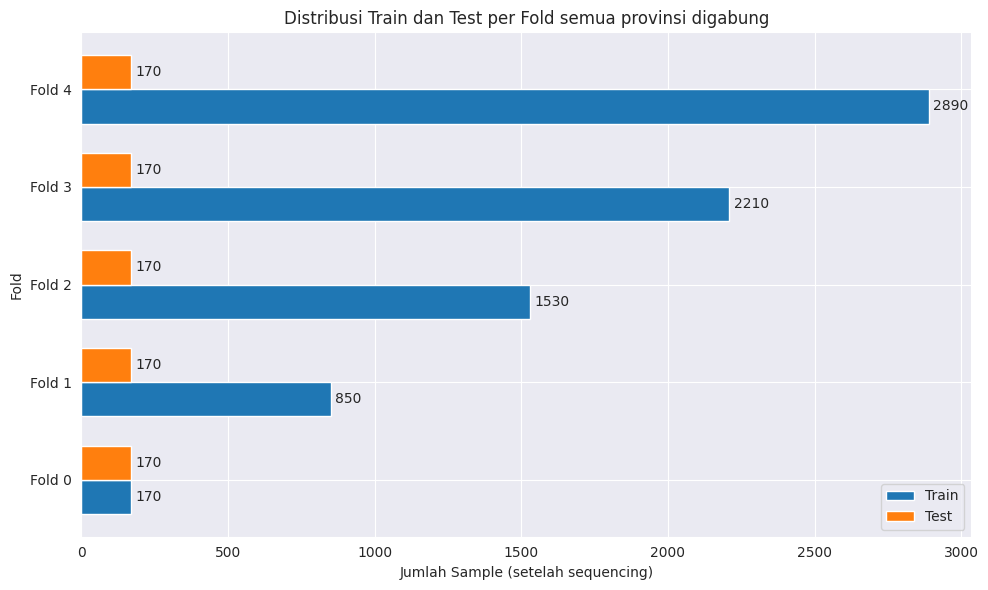

In [28]:
import matplotlib.pyplot as plt

# Hitung total sample per fold dari hasil multi_step_target()
train_counts = []
test_counts = []

for i in range(kfold):
    train_counts.append(len(X_train_fold[i]))
    test_counts.append(len(X_test_fold[i]))

# Visualisasi bar chart horizontal
folds = list(range(kfold))
bar_height = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

train_bar = ax.barh([f - bar_height/2 for f in folds], train_counts, bar_height, label='Train')
test_bar = ax.barh([f + bar_height/2 for f in folds], test_counts, bar_height, label='Test')

ax.set_ylabel('Fold')
ax.set_xlabel('Jumlah Sample (setelah sequencing)')
ax.set_title('Distribusi Train dan Test per Fold semua provinsi digabung')
ax.set_yticks(folds)
ax.set_yticklabels([f'Fold {i}' for i in folds])
ax.legend(loc='lower right')

# Tambahkan nilai di samping bar
for bar in train_bar + test_bar:
    width = bar.get_width()
    ax.annotate(f'{width}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),
                textcoords="offset points",
                ha='left', va='center')

plt.tight_layout()
plt.show()


# LIHAT DATA SETELAH MULTISTEPS

In [29]:
X_train_fold[0]

array([[[ 0.00000000e+00, -3.47501751e-01, -8.68667389e-01, ...,
          1.77635684e-15, -2.84217094e-14, -6.10082867e-02],
        [ 0.00000000e+00, -3.47501751e-01, -9.78769818e-01, ...,
          1.77635684e-15, -2.84217094e-14, -6.10082867e-02],
        [ 0.00000000e+00, -3.47501751e-01, -9.00474757e-01, ...,
          1.77635684e-15, -2.84217094e-14, -6.10082867e-02],
        ...,
        [ 0.00000000e+00, -3.47501751e-01,  2.95971641e-01, ...,
          1.77635684e-15, -2.84217094e-14, -1.37769829e+00],
        [ 0.00000000e+00, -3.47501751e-01, -7.11261693e-01, ...,
          1.77635684e-15, -2.84217094e-14, -6.10082867e-02],
        [ 0.00000000e+00, -3.47501751e-01,  3.90578173e-01, ...,
          1.77635684e-15, -2.84217094e-14, -1.04852579e+00]],

       [[ 0.00000000e+00, -3.47501751e-01, -9.78769818e-01, ...,
          1.77635684e-15, -2.84217094e-14, -6.10082867e-02],
        [ 0.00000000e+00, -3.47501751e-01, -9.00474757e-01, ...,
          1.77635684e-15, -2.84217094e

# FORECASTING KESELURUHAN PROVINCE

In [30]:
best_f1 = -99999
y_true_best = []
y_pred_best = []

In [31]:
# def eval_fold(Y_true, Y_pred, best_f1, y_true_best, y_pred_best):
#     # Inisialisasi penyimpanan metrik
#     eval_metric = {'accuracies': [], 'f1_scores': [], 'recalls': [], 'precisions': []}
#     y_true_all = []
#     y_pred_all = []
    
#     for i in range(len(Y_true)):
#         # Flatten untuk evaluasi
#         y_true = Y_true[i].flatten()
#         y_pred = Y_pred[i].flatten()
    
#         y_true_all.extend(y_true)
#         y_pred_all.extend(y_pred)
    
#         # Hitung metrik
#         acc = accuracy_score(y_true, y_pred)
#         f1 = f1_score(y_true, y_pred, average='macro')
#         recall = recall_score(y_true, y_pred, average='macro')
#         precision = precision_score(y_true, y_pred, average='macro')
    
#         # Simpan ke list
#         eval_metric['accuracies'].append(acc)
#         eval_metric['f1_scores'].append(f1)
#         eval_metric['recalls'].append(recall)
#         eval_metric['precisions'].append(precision)
    
#         print('=' * 40)
#         print(f"Evaluasi untuk Fold ke-{i+1}:")
#         print(classification_report(y_true, y_pred))
#         print('=' * 40)
    
#     # --- Evaluasi Rata-Rata ---
#     print()
#     print('='*10, 'HASIL RATA - RATA KESELURUHAN','='*10)
#     print("=" * 40)
#     print(f" Average Accuracy : {np.mean(eval_metric['accuracies']):.4f}")
#     print(f" Average F1 Score : {np.mean(eval_metric['f1_scores']):.4f}")
#     print(f" Average Recall   : {np.mean(eval_metric['recalls']):.4f}")
#     print(f" Average Precision: {np.mean(eval_metric['precisions']):.4f}")
#     print("=" * 40)
    
#     # --- Confusion Matrix ---
#     cm = confusion_matrix(y_true_all, y_pred_all)
    
#     plt.figure(figsize=(6, 5))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Late', 'Late'], yticklabels=['Not Late', 'Late'])
#     plt.title('Confusion Matrix Keseluruhan')
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.show()
    
#     # --- DataFrame Hasil Evaluasi per Fold ---
#     df_CV_all_province = pd.DataFrame({
#         'Fold 1': [eval_metric['accuracies'][0], eval_metric['f1_scores'][0], eval_metric['recalls'][0], eval_metric['precisions'][0]],
#         'Fold 2': [eval_metric['accuracies'][1], eval_metric['f1_scores'][1], eval_metric['recalls'][1], eval_metric['precisions'][1]],
#         'Fold 3': [eval_metric['accuracies'][2], eval_metric['f1_scores'][2], eval_metric['recalls'][2], eval_metric['precisions'][2]],
#         'Fold 4': [eval_metric['accuracies'][3], eval_metric['f1_scores'][3], eval_metric['recalls'][3], eval_metric['precisions'][3]],
#         'Fold 5': [eval_metric['accuracies'][4], eval_metric['f1_scores'][4], eval_metric['recalls'][4], eval_metric['precisions'][4]],
#     }, index=['Accuracy', 'F1 Score', 'Recall', 'Precision'])
    
#     # --- DataFrame Hasil Rata-rata Keseluruhan ---
#     df_MEAN_all_province = pd.DataFrame({
#         'Mean': [np.mean(eval_metric['accuracies']), np.mean(eval_metric['f1_scores']), np.mean(eval_metric['recalls']), np.mean(eval_metric['precisions'])]
#     }, index=['Accuracy', 'F1 Score', 'Recall', 'Precision'])
    
#     # Tampilkan DataFrame
#     print("\nDataFrame per Fold:")
#     print(df_CV_all_province)
    
#     print("\nDataFrame Rata-rata Keseluruhan:")
#     print(df_MEAN_all_province)

#     if np.mean(eval_metric['f1_scores']) > best_f1:
#         return np.mean(eval_metric['f1_scores']), Y_true, Y_pred, df_MEAN_all_province
#     else:
#         return best_f1, y_true_best, y_pred_best, df_MEAN_all_province

In [32]:
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, classification_report,
    roc_auc_score, average_precision_score, confusion_matrix
)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def eval_fold(Y_true, Y_pred, best_f1, y_true_best, y_pred_best):
    # Inisialisasi penyimpanan metrik
    eval_metric = {'accuracies': [], 'f1_scores': [], 'recalls': [], 'precisions': [],
                   'auprcs': [], 'aurocs': []}
    y_true_all = []
    y_pred_all = []
    
    for i in range(len(Y_true)):
        # Flatten untuk evaluasi
        y_true = Y_true[i].flatten()
        y_pred = Y_pred[i].flatten()
    
        y_true_all.extend(y_true)
        y_pred_all.extend(y_pred)
    
        # Hitung metrik
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        precision = precision_score(y_true, y_pred, average='macro')
    
        # Hitung AUPRC dan AUROC
        try:
            auprc = average_precision_score(y_true, y_pred)
        except:
            auprc = float('nan')

        try:
            auroc = roc_auc_score(y_true, y_pred)
        except:
            auroc = float('nan')

        # Simpan ke list
        eval_metric['accuracies'].append(acc)
        eval_metric['f1_scores'].append(f1)
        eval_metric['recalls'].append(recall)
        eval_metric['precisions'].append(precision)
        eval_metric['auprcs'].append(auprc)
        eval_metric['aurocs'].append(auroc)
    
        print('=' * 40)
        print(f"Evaluasi untuk Fold ke-{i+1}:")
        print(classification_report(y_true, y_pred))
        print('=' * 40)
    
    # --- Evaluasi Rata-Rata ---
    print()
    print('='*10, 'HASIL RATA - RATA KESELURUHAN','='*10)
    print("=" * 40)
    print(f" Average Accuracy : {np.mean(eval_metric['accuracies']):.4f}")
    print(f" Average F1 Score : {np.mean(eval_metric['f1_scores']):.4f}")
    print(f" Average Recall   : {np.mean(eval_metric['recalls']):.4f}")
    print(f" Average Precision: {np.mean(eval_metric['precisions']):.4f}")
    print(f" Average AUPRC    : {np.nanmean(eval_metric['auprcs']):.4f}")
    print(f" Average AUROC    : {np.nanmean(eval_metric['aurocs']):.4f}")
    print("=" * 40)
    
    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true_all, y_pred_all)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Late', 'Late'], yticklabels=['Not Late', 'Late'])
    plt.title('Confusion Matrix Keseluruhan')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # --- DataFrame Hasil Evaluasi per Fold ---
    df_CV_all_province = pd.DataFrame({
        'Fold 1': [eval_metric['accuracies'][0], eval_metric['f1_scores'][0], eval_metric['recalls'][0], eval_metric['precisions'][0], eval_metric['auprcs'][0], eval_metric['aurocs'][0]],
        'Fold 2': [eval_metric['accuracies'][1], eval_metric['f1_scores'][1], eval_metric['recalls'][1], eval_metric['precisions'][1], eval_metric['auprcs'][1], eval_metric['aurocs'][1]],
        'Fold 3': [eval_metric['accuracies'][2], eval_metric['f1_scores'][2], eval_metric['recalls'][2], eval_metric['precisions'][2], eval_metric['auprcs'][2], eval_metric['aurocs'][2]],
        'Fold 4': [eval_metric['accuracies'][3], eval_metric['f1_scores'][3], eval_metric['recalls'][3], eval_metric['precisions'][3], eval_metric['auprcs'][3], eval_metric['aurocs'][3]],
        'Fold 5': [eval_metric['accuracies'][4], eval_metric['f1_scores'][4], eval_metric['recalls'][4], eval_metric['precisions'][4], eval_metric['auprcs'][4], eval_metric['aurocs'][4]],
    }, index=['Accuracy', 'F1 Score', 'Recall', 'Precision', 'AUPRC', 'AUROC'])
    
    # --- DataFrame Hasil Rata-rata Keseluruhan ---
    df_MEAN_all_province = pd.DataFrame({
        'Mean': [
            np.mean(eval_metric['accuracies']),
            np.mean(eval_metric['f1_scores']),
            np.mean(eval_metric['recalls']),
            np.mean(eval_metric['precisions']),
            np.nanmean(eval_metric['auprcs']),
            np.nanmean(eval_metric['aurocs'])
        ]
    }, index=['Accuracy', 'F1 Score', 'Recall', 'Precision', 'AUPRC', 'AUROC'])
    
    # Tampilkan DataFrame
    print("\nDataFrame per Fold:")
    print(df_CV_all_province)
    
    print("\nDataFrame Rata-rata Keseluruhan:")
    print(df_MEAN_all_province)

    if np.mean(eval_metric['f1_scores']) > best_f1:
        return np.mean(eval_metric['f1_scores']), Y_true, Y_pred, df_MEAN_all_province
    else:
        return best_f1, y_true_best, y_pred_best, df_MEAN_all_province


## 1) Logistic Regression

In [33]:
# print('='*10, 'FOWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}

# # Looping tiap fold
# for i in range(kfold):

#     X_train = X_train_fold[i].reshape(X_train_fold[i].shape[0], -1)
#     X_test = X_test_fold[i].reshape(X_test_fold[i].shape[0], -1)

#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print("X_train.shape",X_train.shape)
#     print("X_test.shape",X_test.shape)
#     print("X_test.shape",y_train.shape)

#     model = MultiOutputClassifier(LogisticRegression(max_iter=100))
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     y_true[i] = y_test
#     y_preds[i] = y_pred

# best_f1, y_true_best, y_pred_best, df_lr = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)

## 2) Random Forest CLF

In [34]:
# print('='*10, 'FOWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}

# # Looping tiap fold
# for i in range(5):
#     X_train = X_train_fold[i].reshape(X_train_fold[i].shape[0], -1)
#     X_test = X_test_fold[i].reshape(X_test_fold[i].shape[0], -1)
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print("X_train.shape",X_train.shape)
#     print("X_test.shape",X_test.shape)

#     model = MultiOutputClassifier(RandomForestClassifier(n_estimators=50, max_depth=5, random_state=seed))
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     y_true[i] = y_test
#     y_preds[i] = y_pred

# best_f1, y_true_best, y_pred_best, df_rf = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)

## 3) XGBOOST

In [35]:
# print('='*10, 'FOWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}

# # Looping tiap fold
# for i in range(5):
    
#     X_train = X_train_fold[i].reshape(X_train_fold[i].shape[0], -1)
#     X_test = X_test_fold[i].reshape(X_test_fold[i].shape[0], -1)
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print("X_train.shape",X_train.shape)
#     print("X_test.shape",X_test.shape)

#     model = MultiOutputClassifier(XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed))
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     y_true[i] = y_test
#     y_preds[i] = y_pred

# best_f1, y_true_best, y_pred_best, df_xgb = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)

## 4) SVM

In [36]:


# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}

# # Looping tiap fold
# for i in range(5):
#     # Ambil fitur terakhir (misalnya fitur dari time step terakhir)
#     X_train = X_train_fold[i].reshape(X_train_fold[i].shape[0], -1)
#     X_test = X_test_fold[i].reshape(X_test_fold[i].shape[0], -1)
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print("X_train.shape",X_train.shape)
#     print("X_test.shape",X_test.shape)

#     # Inisialisasi model SVM
#     svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=False, random_state=seed)
#     model = MultiOutputClassifier(svm)
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)

#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi hasil
# best_f1, y_true_best, y_pred_best, df_svm = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 5) CATBOOST

In [37]:


# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}

# for i in range(5):
#     X_train = X_train_fold[i].reshape(X_train_fold[i].shape[0], -1)
#     X_test = X_test_fold[i].reshape(X_test_fold[i].shape[0], -1)
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print("X_train.shape",X_train.shape)
#     print("X_test.shape",X_test.shape)

#     # Inisialisasi model CatBoost
#     catboost_model = CatBoostClassifier(
#         iterations=50,
#         learning_rate=0.1,
#         depth=5,
#         verbose=0,
#         random_seed=seed
#     )
#     model = MultiOutputClassifier(catboost_model)
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)

#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi hasil
# best_f1, y_true_best, y_pred_best, df_catboost = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 6) LIGHTGBM

In [38]:
# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}

# for i in range(5):
#     X_train = X_train_fold[i].reshape(X_train_fold[i].shape[0], -1)
#     X_test = X_test_fold[i].reshape(X_test_fold[i].shape[0], -1)
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print("X_train.shape",X_train.shape)
#     print("X_test.shape",X_test.shape)

#     # Inisialisasi model LightGBM
#     lgbm_model = LGBMClassifier(
#         n_estimators=50,
#         learning_rate=0.1,
#         max_depth=5,
#         random_state=seed,
#         verbose=-1
#     )
#     model = MultiOutputClassifier(lgbm_model)
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)

#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi hasil
# best_f1, y_true_best, y_pred_best, df_lightgbm = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 7) KNN

In [39]:
# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}

# for i in range(5):
#     X_train = X_train_fold[i].reshape(X_train_fold[i].shape[0], -1)
#     X_test = X_test_fold[i].reshape(X_test_fold[i].shape[0], -1)
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print("X_train.shape", X_train.shape)
#     print("X_test.shape", X_test.shape)

#     # Ganti model ke KNN
#     knn_model = KNeighborsClassifier(n_neighbors=3)  # kamu bisa sesuaikan jumlah tetangga
#     model = MultiOutputClassifier(knn_model)
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)

#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi hasil
# best_f1, y_true_best, y_pred_best, df_knn = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 8) Gradient Boosting

In [40]:
# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}

# for i in range(5):
#     X_train = X_train_fold[i].reshape(X_train_fold[i].shape[0], -1)
#     X_test = X_test_fold[i].reshape(X_test_fold[i].shape[0], -1)
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print("X_train.shape", X_train.shape)
#     print("X_test.shape", X_test.shape)

#     # Ganti model ke Naive Bayes dengan hyperparameter
#     gb_model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42)  # defaultnya 1e-9, bisa dicoba 1e-8, 1e-10, dst
#     model = MultiOutputClassifier(gb_model)
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)

#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi hasil
# best_f1, y_true_best, y_pred_best, df_gb = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 9) MLP CLassifier

In [41]:
# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}

# for i in range(5):
#     X_train = X_train_fold[i].reshape(X_train_fold[i].shape[0], -1)
#     X_test = X_test_fold[i].reshape(X_test_fold[i].shape[0], -1)
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print("X_train.shape", X_train.shape)
#     print("X_test.shape", X_test.shape)

#     # Ganti model ke MLPClassifier (Neural Network)
#     mlp_model = MLPClassifier(
#         hidden_layer_sizes=(32,16),  # bisa kamu ubah jadi (128, 64), dst
#         activation='relu',          # alternatif: 'tanh', 'logistic'
#         solver='adam',              # atau 'sgd', 'lbfgs'
#         learning_rate='adaptive',   # atau 'constant', 'invscaling'
#         max_iter=300,               # bisa ditambah kalau convergence warning
#         early_stopping=True,
#         random_state=42
#     )
    
#     model = MultiOutputClassifier(mlp_model)
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)

#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi hasil
# best_f1, y_true_best, y_pred_best, df_mlp = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 10) CNN

In [42]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Mengecek validasi loss
    patience=15,   
    min_delta = 0.01, # Jika tidak membaik selama 5 epoch, hentikan training
    restore_best_weights=True # Kembalikan bobot terbaik sebelum overfitting terjadi
)

Regularisasi = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)


In [43]:
# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}

# def create_cnn_model(input_shape, output_dim):
#     model = Sequential()
#     model.add(Conv1D(128, kernel_size=2, activation='relu', padding='same', input_shape=input_shape))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))
#     model.add(Conv1D(64, kernel_size=2, activation='relu', padding='same'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))
#     model.add(Conv1D(32, kernel_size=2, activation='relu', padding='same'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))
#     model.add(Flatten())
#     model.add(Dense(16, activation='relu'))
#     model.add(Dense(output_dim, activation='sigmoid'))
#     model.compile(
#         optimizer=Adam(learning_rate=0.001),
#         loss='binary_crossentropy',
#         metrics=['accuracy'],
#         jit_compile=False
#     )
#     return model

# # Looping tiap fold
# for i in range(5):
#     X_train = X_train_fold[i]
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print("X_train.shape",X_train.shape)
#     print("X_test.shape",X_test.shape)

#     model = create_cnn_model(X_train.shape[1:], y_train.shape[1])
#     model.fit(
#     X_train, y_train,
#     epochs=50,
#     batch_size=4,
#     validation_data=(X_test, y_test),  # Pastikan ada validasi data
#     callbacks=[early_stopping, Regularisasi],
#     verbose=1)


#     y_pred_prob = model.predict(X_test)
#     y_pred = (y_pred_prob >= 0.7).astype(int)

#     y_true[i] = y_test
#     y_preds[i] = y_pred

# best_f1, y_true_best, y_pred_best, df_cnn = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)

## 11) LSTM

In [44]:
# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}

# def create_lstm_model(input_shape, output_dim):
#     model = Sequential()
#     model.add(LSTM(128,return_sequences=True, input_shape=input_shape))
#     model.add(Dropout(0.1))
#     model.add(LSTM(64,return_sequences=True))
#     model.add(Dropout(0.1))
#     model.add(LSTM(32,return_sequences=False))  # Layer terakhir return_sequences=False
#     model.add(Dropout(0.1))
#     model.add(Dense(16, activation='relu'))
#     model.add(Dense(output_dim, activation='sigmoid'))  # untuk output biner
#     model.compile(
#         optimizer=Adam(learning_rate=0.001),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model


# for i in range(5):
#     X_train = X_train_fold[i]
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print("X_train.shape",X_train.shape)
#     print("X_test.shape",X_test.shape)

#     model = create_lstm_model(X_train.shape[1:], y_train.shape[1])
#     model.fit(
#     X_train, y_train,
#     epochs=50,
#     batch_size=4,
#     validation_data=(X_test, y_test),  # Pastikan ada validasi data
#     callbacks=[early_stopping, Regularisasi],
#     verbose=1
# )


#     y_pred_prob = model.predict(X_test)
#     y_pred = (y_pred_prob >= 0.7).astype(int)

#     y_true[i] = y_test
#     y_preds[i] = y_pred

# best_f1, y_true_best, y_pred_best, df_lstm = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)

## 12) CNN LSTM

In [45]:
# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}

# def create_cnn_lstm_model(input_shape, output_dim):
#     model = Sequential()
    
#     # CNN Feature Extraction
#     model.add(Conv1D(128, kernel_size=2, activation='relu',padding='same', input_shape=input_shape))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))

#     model.add(Conv1D(64, kernel_size=2, activation='relu',padding='same'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))

#     model.add(Conv1D(32, kernel_size=2, activation='relu',padding='same'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))

#     # LSTM for temporal sequence
#     model.add(LSTM(128, return_sequences=True))  # Bisa diubah ke return_sequences=True kalau mau stack lebih banyak
#     model.add(Dropout(0.1))
#     model.add(LSTM(64, return_sequences=True))  # Bisa diubah ke return_sequences=True kalau mau stack lebih banyak
#     model.add(Dropout(0.1))
#     model.add(LSTM(32, return_sequences=False))  # Bisa diubah ke return_sequences=True kalau mau stack lebih banyak
#     model.add(Dropout(0.1))

#     # Fully Connected
#     model.add(Dense(16, activation='relu'))

#     model.add(Dense(output_dim, activation='sigmoid'))  # Untuk klasifikasi biner
    
#     model.compile(
#         optimizer=Adam(learning_rate=0.001),
#         loss='binary_crossentropy',
#         metrics=['accuracy'],
#         jit_compile=False
#     )
#     return model


# # --- Training dan Evaluasi per Fold ---
# for i in range(5):
#     X_train = X_train_fold[i]
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print("X_train.shape",X_train.shape)
#     print("X_test.shape",X_test.shape)

#     model = create_cnn_lstm_model(X_train.shape[1:], y_train.shape[1])
#     model.fit(
#     X_train, y_train,
#     epochs=50,
#     batch_size=4,
#     validation_data=(X_test, y_test),  # Pastikan ada validasi data
#     callbacks=[early_stopping, Regularisasi],
#     verbose=1
# )

#     y_pred_prob = model.predict(X_test)
#     y_pred = (y_pred_prob >= 0.7).astype(int)

#     y_true[i] = y_test
#     y_preds[i] = y_pred

# best_f1, y_true_best, y_pred_best, df_cnn_lstm = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)

## 13) BiLSTM

In [46]:
# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}
# dropout_rate = 0.1  # Menyamakan dengan CNN-LSTM

# def create_bilstm_model(input_shape, output_dim):
#     model = Sequential()
    
#     # BiLSTM layers
#     model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
#     model.add(Dropout(dropout_rate))

#     model.add(Bidirectional(LSTM(64, return_sequences=True)))
#     model.add(Dropout(dropout_rate))

#     model.add(Bidirectional(LSTM(32, return_sequences=False)))
#     model.add(Dropout(dropout_rate))

#     # Fully Connected
#     model.add(Dense(16, activation='relu'))
#     model.add(Dense(output_dim, activation='sigmoid'))  # Untuk klasifikasi biner
    
#     model.compile(
#         optimizer='adam',
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# # --- Training dan Evaluasi per Fold ---
# for i in range(5):
#     X_train = X_train_fold[i]
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print("X_train.shape", X_train.shape)
#     print("X_test.shape", X_test.shape)

#     model = create_bilstm_model(X_train.shape[1:], y_train.shape[1])
#     model.fit(
#     X_train, y_train,
#     epochs=50,
#     batch_size=4,
#     validation_data=(X_test, y_test),  # Pastikan ada validasi data
#     callbacks=[early_stopping, Regularisasi],
#     verbose=1
# )


#     y_pred_prob = model.predict(X_test)
#     y_pred = (y_pred_prob >= 0.7).astype(int)

#     y_true[i] = y_test
#     y_preds[i] = y_pred

# best_f1, y_true_best, y_pred_best, df_bilstm = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)

## EVALUASI MODEL STANDALONE FORECAST (TRADITIONAL / ML / DL)

In [47]:
# df_ML = pd.concat([df_lr, df_xgb, df_svm, df_catboost, df_lightgbm, df_knn, df_gb, df_mlp],axis=1)
# df_ML.columns = ['knn','xgb','svm','catboost','lightgbm','knn','gb','mlp']
# print(df_ML)
# df_DL = pd.concat([df_cnn, df_lstm, df_cnn_lstm, df_bilstm],axis=1)
# df_DL.columns = ['cnn','lstm','cnn_lstm','bilstm']
# print(df_DL)

In [48]:
# # Set seaborn style and color palette
# sns.set(style="whitegrid")
# sns.set_palette("Paired")

# # Ubah nama kolom df_ML yang duplikat ('knn' dua kali)
# df_ML.columns = ['lr', 'xgb', 'svm', 'catboost', 'lightgbm', 'knn', 'gb', 'mlp']  # ganti satu 'knn' ke 'lr' jika itu Logistic Regression

# # Transpose agar model jadi index, lalu reset untuk melt
# ml_df = df_ML.T.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
# ml_df.rename(columns={'index': 'Model'}, inplace=True)

# dl_df = df_DL.T.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
# dl_df.rename(columns={'index': 'Model'}, inplace=True)

# # Function to add text on bars
# def add_bar_values(ax):
#     for p in ax.patches:
#         height = p.get_height()
#         ax.annotate(f'{height:.3f}',
#                     (p.get_x() + p.get_width() / 2., height),
#                     ha='center', va='center',
#                     xytext=(0, 8), textcoords='offset points', fontsize=8)

# # Plot ML Models
# plt.figure(figsize=(11.5, 6))
# ax1 = sns.barplot(data=ml_df, x='Metric', y='Value', hue='Model')
# add_bar_values(ax1)
# plt.title('Figure 1: Perbandingan Performa Model Machine Learning')
# plt.ylim(0.4, 1.0)
# plt.legend(title='Model', bbox_to_anchor=(1.01, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

# # Plot DL Models
# plt.figure(figsize=(11.5, 6))
# ax2 = sns.barplot(data=dl_df, x='Metric', y='Value', hue='Model')
# add_bar_values(ax2)
# plt.title('Figure 2: Perbandingan Performa Model Deep Learning')
# plt.ylim(0.4, 1.0)
# plt.legend(title='Model', bbox_to_anchor=(1.01, 1), loc='upper left')
# plt.tight_layout()
# plt.show()


In [49]:
# # Plot DL Models
# plt.figure(figsize=(12, 6))
# ax2 = sns.barplot(data=dl_df, x='Metric', y='Value', hue='Model')
# add_bar_values(ax2)
# plt.title('Figure 2: Perbandingan Performa Model Deep Learning')
# plt.ylim(0.4, 1.0)
# plt.legend(title='Model')
# plt.tight_layout()
# plt.show()


# HYBRID MODELS

## 1) HYBRID XGB + CATBOOST

In [50]:

# print('='*10, 'FORWARD CHAINING CROSS VALIDATION', '='*10)

# y_true = {}
# y_preds = {}

# # Loop cross-validation
# for i in range(5):
#     print(f"\nFold ke-{i+1}")
#     X_train = X_train_fold[i]
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print('fitur_sebelum_encode = ', X_train.shape)

#     # Pastikan X_train dan X_test memiliki 2 dimensi (n_samples, n_features)
#     if len(X_train.shape) == 3:
#         # Flattening jika data memiliki 3 dimensi
#         X_train_encoded = X_train.reshape(X_train.shape[0], -1)
#         X_test_encoded = X_test.reshape(X_test.shape[0], -1)
#         print('Data sudah di-flatten, fitur_encode = ', X_train_encoded.shape)
#     else:
#         # Jika data sudah dalam 2 dimensi, tidak perlu diubah
#         X_train_encoded = X_train
#         X_test_encoded = X_test
#         print('fitur_encode = ', X_train_encoded.shape)

#     # Step 2: Voting Classifier (Hybrid RF, XGB, CatBoost)
#     xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
#     catboost = CatBoostClassifier(
#         iterations=50,
#         learning_rate=0.1,
#         depth=5,
#         verbose=0,
#         random_seed=seed
#     )

#     voting_clf = VotingClassifier(
#         estimators=[('xgb', xgb), ('catboost', catboost)],
#         voting='hard',
#         n_jobs=-1
#     )

#     hybrid_model = MultiOutputClassifier(voting_clf)
#     hybrid_model.fit(X_train_encoded, y_train)

#     # Step 3: Predict & simpan hasil
#     y_pred = hybrid_model.predict(X_test_encoded)
#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi model
# best_f1, y_true_best, y_pred_best, df_hybrid_xgb_cat = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 2) HYBRID CNN + XGB + CATBOOST

In [51]:

# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}

# def create_cnn_encoder(input_shape):
#     model = Sequential()
#     model.add(Conv1D(128, kernel_size=2, activation='relu', padding='same', input_shape=input_shape))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))
#     model.add(Conv1D(64, kernel_size=2, activation='relu', padding='same'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))
#     model.add(Conv1D(32, kernel_size=2, activation='relu', padding='same'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))
#     model.compile(
#         optimizer=Adam(learning_rate=0.001),
#         loss='binary_crossentropy',
#         metrics=['accuracy'],
#         jit_compile=False
#     )
#     return model

# # Loop cross-validation
# for i in range(5):
#     print(f"\nFold ke-{i+1}")
#     X_train = X_train_fold[i]
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print('fitur_sebelum_encode = ', X_train.shape)
#     # Step 1: Encode fitur dengan MLP
#     encoder = create_cnn_encoder(X_train.shape[1:])
#     X_train_encoded = encoder.predict(X_train)
#     X_test_encoded = encoder.predict(X_test)

#     # Flatten the encoded features
#     X_train_encoded = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
#     X_test_encoded = X_test_encoded.reshape(X_test_encoded.shape[0], -1)
#     print('fitur_encode = ', X_train_encoded.shape)
  
#     # Step 2: Voting Classifier (Hybrid XGB, CatBoost)
#     xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
#     catboost = CatBoostClassifier(
#         iterations=50,
#         learning_rate=0.1,
#         depth=5,
#         verbose=0,
#         random_seed=seed
#     )

#     # Menggabungkan model dengan VotingClassifier
#     voting_clf = VotingClassifier(
#         estimators=[
#             ('xgb', xgb),
#             ('catboost', catboost),
#         ],
#         voting='hard', 
#         n_jobs=-1
#     )

#     hybrid_model = MultiOutputClassifier(voting_clf)
#     hybrid_model.fit(X_train_encoded, y_train)

#     # Step 3: Predict & simpan hasil
#     y_pred = hybrid_model.predict(X_test_encoded)
#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi model
# best_f1, y_true_best, y_pred_best, df_hybrid_cnn = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 3) HYBRID LSTM + XGB + CATBOOST

In [52]:


# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}

# def create_lstm_encoder(input_shape):
#     model = Sequential()
#     model.add(LSTM(128,return_sequences=True, input_shape=input_shape))
#     model.add(Dropout(0.1))
#     model.add(LSTM(64,return_sequences=True))
#     model.add(Dropout(0.1))
#     model.add(LSTM(32,return_sequences=False))  # Layer terakhir return_sequences=False
#     model.add(Dropout(0.1))
#     model.compile(
#         optimizer=Adam(learning_rate=0.001),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# # Loop cross-validation
# for i in range(5):
#     print(f"\nFold ke-{i+1}")
#     X_train = X_train_fold[i]
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print('fitur_sebelum_encode = ', X_train.shape)
#     # Step 1: Encode fitur dengan MLP
#     encoder = create_lstm_encoder(X_train.shape[1:])
#     X_train_encoded = encoder.predict(X_train)
#     X_test_encoded = encoder.predict(X_test)

#     # Flatten the encoded features
#     X_train_encoded = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
#     X_test_encoded = X_test_encoded.reshape(X_test_encoded.shape[0], -1)
#     print('fitur_encode = ', X_train_encoded.shape)
  
#     # Step 2: Voting Classifier (Hybrid XGB, CatBoost)
#     xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
#     catboost = CatBoostClassifier(
#         iterations=50,
#         learning_rate=0.1,
#         depth=5,
#         verbose=0,
#         random_seed=seed
#     )

#     # Menggabungkan model dengan VotingClassifier
#     voting_clf = VotingClassifier(
#         estimators=[
#             ('xgb', xgb),
#             ('catboost', catboost),
#         ],
#         voting='hard', 
#         n_jobs=-1
#     )

#     hybrid_model = MultiOutputClassifier(voting_clf)
#     hybrid_model.fit(X_train_encoded, y_train)

#     # Step 3: Predict & simpan hasil
#     y_pred = hybrid_model.predict(X_test_encoded)
#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi model
# best_f1, y_true_best, y_pred_best, df_hybrid_lstm = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 4) HYBRID CNN LSTM + XGB + CATBOOST

In [53]:

# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}

# def create_cnn_lstm_encoder(input_shape):
#     model = Sequential()
    
#     # CNN Feature Extraction
#     model.add(Conv1D(128, kernel_size=2, activation='relu',padding='same', input_shape=input_shape))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))

#     model.add(Conv1D(64, kernel_size=2, activation='relu',padding='same'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))

#     model.add(Conv1D(32, kernel_size=2, activation='relu',padding='same'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))

#     # LSTM for temporal sequence
#     model.add(LSTM(128, return_sequences=True))  # Bisa diubah ke return_sequences=True kalau mau stack lebih banyak
#     model.add(Dropout(0.1))
#     model.add(LSTM(64, return_sequences=True))  # Bisa diubah ke return_sequences=True kalau mau stack lebih banyak
#     model.add(Dropout(0.1))
#     model.add(LSTM(32, return_sequences=False))  # Bisa diubah ke return_sequences=True kalau mau stack lebih banyak
#     model.add(Dropout(0.1))
#     model.compile(
#         optimizer=Adam(learning_rate=0.001),
#         loss='binary_crossentropy',
#         metrics=['accuracy'],
#         jit_compile=False
        
#     )
#     return model

# # Loop cross-validation
# for i in range(5):
#     print(f"\nFold ke-{i+1}")
#     X_train = X_train_fold[i]
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print('fitur_sebelum_encode = ', X_train.shape)
#     # Step 1: Encode fitur dengan MLP
#     encoder = create_cnn_lstm_encoder(X_train.shape[1:])
#     X_train_encoded = encoder.predict(X_train)
#     X_test_encoded = encoder.predict(X_test)

#     # Flatten the encoded features
#     X_train_encoded = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
#     X_test_encoded = X_test_encoded.reshape(X_test_encoded.shape[0], -1)
#     print('fitur_encode = ', X_train_encoded.shape)
  
#     # Step 2: Voting Classifier (Hybrid XGB, CatBoost)
#     xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
#     catboost = CatBoostClassifier(
#         iterations=50,
#         learning_rate=0.1,
#         depth=5,
#         verbose=0,
#         random_seed=seed
#     )

#     # Menggabungkan model dengan VotingClassifier
#     voting_clf = VotingClassifier(
#         estimators=[
#             ('xgb', xgb),
#             ('catboost', catboost),
#         ],
#         voting='hard', 
#         n_jobs=-1
#     )

#     hybrid_model = MultiOutputClassifier(voting_clf)
#     hybrid_model.fit(X_train_encoded, y_train)

#     # Step 3: Predict & simpan hasil
#     y_pred = hybrid_model.predict(X_test_encoded)
#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi model
# best_f1, y_true_best, y_pred_best, df_hybrid_cnn_lstm = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 5) HYBRID BiLSTM + XGB CATBOOST

In [54]:
# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}
# dropout_rate=0.1
# def create_bilstm_encoder(input_shape):
#     model = Sequential()
    
#     # BiLSTM layers
#     model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
#     model.add(Dropout(dropout_rate))

#     model.add(Bidirectional(LSTM(64, return_sequences=True)))
#     model.add(Dropout(dropout_rate))

#     model.add(Bidirectional(LSTM(32, return_sequences=False)))
#     model.add(Dropout(dropout_rate))

#     model.compile(
#         optimizer='adam',
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# # Loop cross-validation
# for i in range(5):
#     print(f"\nFold ke-{i+1}")
#     X_train = X_train_fold[i]
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print('fitur_sebelum_encode = ', X_train.shape)
#     # Step 1: Encode fitur dengan MLP
#     encoder = create_bilstm_encoder(X_train.shape[1:])
#     X_train_encoded = encoder.predict(X_train)
#     X_test_encoded = encoder.predict(X_test)

#     # Flatten the encoded features
#     X_train_encoded = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
#     X_test_encoded = X_test_encoded.reshape(X_test_encoded.shape[0], -1)
#     print('fitur_encode = ', X_train_encoded.shape)
  
#     # Step 2: Voting Classifier (Hybrid XGB, CatBoost)
#     xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
#     catboost = CatBoostClassifier(
#         iterations=50,
#         learning_rate=0.1,
#         depth=5,
#         verbose=0,
#         random_seed=seed
#     )

#     # Menggabungkan model dengan VotingClassifier
#     voting_clf = VotingClassifier(
#         estimators=[
#             ('xgb', xgb),
#             ('catboost', catboost),
#         ],
#         voting='hard', 
#         n_jobs=-1
#     )

#     hybrid_model = MultiOutputClassifier(voting_clf)
#     hybrid_model.fit(X_train_encoded, y_train)

#     # Step 3: Predict & simpan hasil
#     y_pred = hybrid_model.predict(X_test_encoded)
#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi model
# best_f1, y_true_best, y_pred_best, df_hybrid_bilstm = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


In [55]:
# df_HYBRID = pd.concat([df_hybrid_xgb_cat, df_hybrid_cnn, df_hybrid_lstm, df_hybrid_cnn_lstm, df_hybrid_bilstm],axis=1)
# df_HYBRID.columns = ['hybrid XGB-CAT', 'hybrid CNN - XGB-CAT', 'hybrid LSTM - XGB-CAT', 'hybrid CNN LSTM - XGB-CAT', 'hybrid BiLSTM - XGB-CAT' ]
# print(df_HYBRID)

In [56]:
# # Set seaborn style and color palette
# sns.set(style="whitegrid")
# sns.set_palette("Paired")


# # Transpose agar model jadi index, lalu reset untuk melt
# # ae_df = df_AE.T.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
# # ae_df.rename(columns={'index': 'Model'}, inplace=True)

# hybrid_df = df_HYBRID.T.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
# hybrid_df.rename(columns={'index': 'Model'}, inplace=True)

# # Function to add text on bars
# def add_bar_values(ax):
#     for p in ax.patches:
#         height = p.get_height()
#         ax.annotate(f'{height:.3f}',
#                     (p.get_x() + p.get_width() / 2., height),
#                     ha='center', va='center',
#                     xytext=(0, 8), textcoords='offset points', fontsize=8)

# # Plot ML Models
# # plt.figure(figsize=(11.5, 6))
# # ax1 = sns.barplot(data=ae_df, x='Metric', y='Value', hue='Model')
# # add_bar_values(ax1)
# # plt.title('Figure 1: Perbandingan Performa Model Autoencoders + best Classifier')
# # plt.ylim(0.4, 1.0)
# # plt.legend(title='Model', bbox_to_anchor=(1.01, 1), loc='upper left')
# # plt.tight_layout()
# # plt.show()

# # Plot DL Models
# plt.figure(figsize=(15, 6))
# ax2 = sns.barplot(data=hybrid_df, x='Metric', y='Value', hue='Model')
# add_bar_values(ax2)
# plt.title('Figure 2: Perbandingan Performa Model Hybrid Deep Learning + best Classifier')
# plt.ylim(0.4, 1.0)
# plt.legend(title='Model', bbox_to_anchor=(1.01, 1), loc='upper left')
# plt.tight_layout()
# plt.show()


# AUTOENCODERS PLAN

In [57]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from sklearn.utils.class_weight import compute_class_weight

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Mengecek validasi loss
    patience=15,
    min_delta=0.01,# Jika tidak membaik selama 5 epoch, hentikan training
    restore_best_weights=True # Kembalikan bobot terbaik sebelum overfitting terjadi
)

Regularisasi = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)


## 1) BASIC AUTOENCODER

coba gabungkan data fitur + latent space nya apakah bagus ????


## 1.1) BASIC AUTOENCODER : TANPA STACKING FEATURES

In [58]:
# from keras.models import Model
# from keras.layers import Input, Dense, Dropout
# import numpy as np
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from sklearn.metrics import f1_score
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt


# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}
# best_f1 = 0
# y_true_best = None
# y_pred_best = None

# def create_autoencoder_encoder(input_shape, dropout_rate=0.1):
#     inputs = Input(shape=input_shape)
#     x = Dense(1024, activation='relu')(inputs)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(768, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     encoded = Dense(640, activation='relu')(x)

#     x = Dropout(dropout_rate)(encoded)
#     x = Dense(768, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1024, activation='relu')(x)
#     decoded = Dense(input_shape[0], activation='sigmoid')(x)

#     autoencoder = Model(inputs, decoded)
#     encoder = Model(inputs, encoded)
#     return autoencoder, encoder


# # Loop cross-validation
# for i in range(5):
#     print(f"\nFold ke-{i+1}")
#     X_train = X_train_fold[i]   # shape: (n_samples, timesteps, features)
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print('fitur_sebelum_encode = ', X_train.shape)

#     # Flatten data: (samples, timesteps, features) → (samples, timesteps * features)
#     X_train_flat = X_train.reshape(X_train.shape[0], -1)
#     X_test_flat = X_test.reshape(X_test.shape[0], -1)
#     input_shape = (X_train_flat.shape[1],)

#     # --- Visualisasi t-SNE sebelum Autoencoder ---
#     # Warna otomatis dari colormap tab10 (maks 10 kelas)
#     cmap = plt.cm.get_cmap("tab10")  # Ganti dengan "tab20" kalau jumlah kelas >10
    
#     # --- Visualisasi t-SNE sebelum Autoencoder ---
#     tsne_before = TSNE(n_components=2, perplexity=30, random_state=seed)
#     X_train_tsne_before = tsne_before.fit_transform(X_train_flat)
    
#     plt.figure(figsize=(6, 5))
#     labels = np.unique(y_train[:, 0])
#     for idx, label in enumerate(labels):
#         plt.scatter(
#             X_train_tsne_before[y_train[:, 0] == label, 0],
#             X_train_tsne_before[y_train[:, 0] == label, 1],
#             color=cmap(idx),  # warna dari colormap berdasarkan indeks
#             label=f"Class {label}", alpha=0.6
#         )
#     plt.title(f"t-SNE Sebelum Autoencoder - Fold {i+1}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     # Step 1: Train autoencoder
#     autoencoder, encoder = create_autoencoder_encoder(input_shape)
#     autoencoder.compile(optimizer='adam', loss='mse')
#     autoencoder.fit(X_train_flat, X_train_flat, epochs=70, batch_size=4, 
#                     verbose=1, callbacks=[early_stopping, Regularisasi], 
#                     validation_data=[X_test_flat, X_test_flat])

#     # Step 2: Encode data
#     X_train_encoded = encoder.predict(X_train_flat)
#     X_test_encoded = encoder.predict(X_test_flat)

#     print('fitur_encode = ', X_train_encoded.shape)

#        # --- Visualisasi t-SNE sesudah Autoencoder ---
#     tsne_after = TSNE(n_components=2, perplexity=30, random_state=seed)
#     X_train_tsne_after = tsne_after.fit_transform(X_train_encoded)
    
#     plt.figure(figsize=(6, 5))
#     for idx, label in enumerate(labels):
#         plt.scatter(
#             X_train_tsne_after[y_train[:, 0] == label, 0],
#             X_train_tsne_after[y_train[:, 0] == label, 1],
#             color=cmap(idx),
#             label=f"Class {label}", alpha=0.6
#         )
#     plt.title(f"t-SNE Sesudah Autoencoder - Fold {i+1}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


#     # Step 3: Define hybrid classifier
#     xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
#     catboost = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=5, verbose=0, random_seed=seed)
#     # gradient_boosting = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=seed)

#     voting_clf = VotingClassifier(
#         estimators=[('xgb', xgb), ('catboost', catboost)],
#         voting='hard', n_jobs=-1
#     )

#     hybrid_model = MultiOutputClassifier(voting_clf)
#     hybrid_model.fit(X_train_encoded, y_train)

#     # Step 4: Predict & simpan hasil
#     y_pred = hybrid_model.predict(X_test_encoded)
#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi model
# best_f1, y_true_best, y_pred_best, df_ae_basic1 = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 1.1.1) BASIC AUTOENCODER : SINGLE CATBOOST CLASSIFIER

In [59]:
# from keras.models import Model
# from keras.layers import Input, Dense, Dropout
# import numpy as np
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from sklearn.metrics import f1_score
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt


# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}
# best_f1 = 0
# y_true_best = None
# y_pred_best = None

# def create_autoencoder_encoder(input_shape, dropout_rate=0.1):
#     inputs = Input(shape=input_shape)
#     x = Dense(1024, activation='relu')(inputs)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(768, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     encoded = Dense(640, activation='relu')(x)

#     x = Dropout(dropout_rate)(encoded)
#     x = Dense(768, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1024, activation='relu')(x)
#     decoded = Dense(input_shape[0], activation='sigmoid')(x)

#     autoencoder = Model(inputs, decoded)
#     encoder = Model(inputs, encoded)
#     return autoencoder, encoder


# # Loop cross-validation
# for i in range(5):
#     print(f"\nFold ke-{i+1}")
#     X_train = X_train_fold[i]   # shape: (n_samples, timesteps, features)
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print('fitur_sebelum_encode = ', X_train.shape)

#     # Flatten data: (samples, timesteps, features) → (samples, timesteps * features)
#     X_train_flat = X_train.reshape(X_train.shape[0], -1)
#     X_test_flat = X_test.reshape(X_test.shape[0], -1)
#     input_shape = (X_train_flat.shape[1],)

#     # --- Visualisasi t-SNE sebelum Autoencoder ---
#     # Warna otomatis dari colormap tab10 (maks 10 kelas)
#     cmap = plt.cm.get_cmap("tab10")  # Ganti dengan "tab20" kalau jumlah kelas >10
    
#     # --- Visualisasi t-SNE sebelum Autoencoder ---
#     tsne_before = TSNE(n_components=2, perplexity=30, random_state=seed)
#     X_train_tsne_before = tsne_before.fit_transform(X_train_flat)
    
#     plt.figure(figsize=(6, 5))
#     labels = np.unique(y_train[:, 0])
#     for idx, label in enumerate(labels):
#         plt.scatter(
#             X_train_tsne_before[y_train[:, 0] == label, 0],
#             X_train_tsne_before[y_train[:, 0] == label, 1],
#             color=cmap(idx),  # warna dari colormap berdasarkan indeks
#             label=f"Class {label}", alpha=0.6
#         )
#     plt.title(f"t-SNE Sebelum Autoencoder - Fold {i+1}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     # Step 1: Train autoencoder
#     autoencoder, encoder = create_autoencoder_encoder(input_shape)
#     autoencoder.compile(optimizer='adam', loss='mse')
#     autoencoder.fit(X_train_flat, X_train_flat, epochs=70, batch_size=4, 
#                     verbose=1, callbacks=[early_stopping, Regularisasi],
#                    validation_data=[X_test_flat, X_test_flat])

#     # Step 2: Encode data
#     X_train_encoded = encoder.predict(X_train_flat)
#     X_test_encoded = encoder.predict(X_test_flat)

#     print('fitur_encode = ', X_train_encoded.shape)

#        # --- Visualisasi t-SNE sesudah Autoencoder ---
#     tsne_after = TSNE(n_components=2, perplexity=30, random_state=seed)
#     X_train_tsne_after = tsne_after.fit_transform(X_train_encoded)
    
#     plt.figure(figsize=(6, 5))
#     for idx, label in enumerate(labels):
#         plt.scatter(
#             X_train_tsne_after[y_train[:, 0] == label, 0],
#             X_train_tsne_after[y_train[:, 0] == label, 1],
#             color=cmap(idx),
#             label=f"Class {label}", alpha=0.6
#         )
#     plt.title(f"t-SNE Sesudah Autoencoder - Fold {i+1}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


#     # Step 3: Define hybrid classifier
#     # xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
#     catboost = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=5, verbose=0, random_seed=seed)
#     # gradient_boosting = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=seed)

#     # voting_clf = VotingClassifier(
#     #     estimators=[('xgb', xgb), ('catboost', catboost)],
#     #     voting='hard', n_jobs=-1
#     # )

#     catboost_model = MultiOutputClassifier(catboost)
#     catboost_model.fit(X_train_encoded, y_train)

#     # Step 4: Predict & simpan hasil
#     y_pred = catboost_model.predict(X_test_encoded)
#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi model
# best_f1, y_true_best, y_pred_best, df_ae_basic_cat = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 1.1.2) BASIC AUTOENCODER : SINGLE CNNLSTM CLASSIFIER

In [60]:
# from keras.models import Model, Sequential
# from keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, LSTM
# from keras.optimizers import Adam
# from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.manifold import TSNE
# from keras.callbacks import EarlyStopping


# # Function to create CNN-LSTM Model
# def create_cnn_lstm_model(input_shape, output_dim):
#     model = Sequential()

#     # CNN Feature Extraction
#     model.add(Conv1D(128, kernel_size=2, activation='relu', padding='same', input_shape=input_shape))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))

#     model.add(Conv1D(64, kernel_size=2, activation='relu', padding='same'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))

#     model.add(Conv1D(32, kernel_size=2, activation='relu', padding='same'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))

#     # LSTM for temporal sequence
#     model.add(LSTM(128, return_sequences=True))
#     model.add(Dropout(0.1))
#     model.add(LSTM(64, return_sequences=True))
#     model.add(Dropout(0.1))
#     model.add(LSTM(32, return_sequences=False))
#     model.add(Dropout(0.1))

#     # Fully Connected
#     model.add(Dense(16, activation='relu'))
#     model.add(Dense(output_dim, activation='sigmoid'))  # Binary Classification
    
#     model.compile(optimizer=Adam(learning_rate=0.001),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model


# # Function to create Autoencoder Encoder
# def create_autoencoder_encoder(input_shape, dropout_rate=0.1):
#     inputs = Input(shape=input_shape)
#     x = Dense(1024, activation='relu')(inputs)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(768, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     encoded = Dense(640, activation='relu')(x)

#     x = Dropout(dropout_rate)(encoded)
#     x = Dense(768, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1024, activation='relu')(x)
#     decoded = Dense(input_shape[0], activation='sigmoid')(x)

#     autoencoder = Model(inputs, decoded)
#     encoder = Model(inputs, encoded)
#     return autoencoder, encoder

# # Main Forward Chaining Cross Validation Loop
# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}
# best_f1 = 0
# y_true_best = None
# y_pred_best = None

# # Loop cross-validation
# for i in range(5):
#     print(f"\nFold ke-{i+1}")
#     X_train = X_train_fold[i]   # shape: (n_samples, timesteps, features)
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print('fitur_sebelum_encode = ', X_train.shape)

#     # Flatten data: (samples, timesteps, features) → (samples, timesteps * features)
#     X_train_flat = X_train.reshape(X_train.shape[0], -1)
#     X_test_flat = X_test.reshape(X_test.shape[0], -1)
#     input_shape = (X_train_flat.shape[1],)

#     # Visualize t-SNE before Autoencoder
#     cmap = plt.cm.get_cmap("tab10")  
#     tsne_before = TSNE(n_components=2, perplexity=30, random_state=seed)
#     X_train_tsne_before = tsne_before.fit_transform(X_train_flat)

#     plt.figure(figsize=(6, 5))
#     labels = np.unique(y_train[:, 0])
#     for idx, label in enumerate(labels):
#         plt.scatter(
#             X_train_tsne_before[y_train[:, 0] == label, 0],
#             X_train_tsne_before[y_train[:, 0] == label, 1],
#             color=cmap(idx),  # warna dari colormap berdasarkan indeks
#             label=f"Class {label}", alpha=0.6
#         )
#     plt.title(f"t-SNE Sebelum Autoencoder - Fold {i+1}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     # Step 1: Train autoencoder
#     autoencoder, encoder = create_autoencoder_encoder(input_shape)
#     autoencoder.compile(optimizer='adam', loss='mse')
#     autoencoder.fit(X_train_flat, X_train_flat, epochs=70, batch_size=4, verbose=1, 
#                     callbacks=[early_stopping, Regularisasi], validation_data=[X_test_flat, X_test_flat])

#     # Step 2: Encode data
#     X_train_encoded = encoder.predict(X_train_flat)
#     X_test_encoded = encoder.predict(X_test_flat)

#     print('fitur_encode = ', X_train_encoded.shape)

#     # Reshape the encoded data for CNN-LSTM (to make it 3D)
#     X_train_encoded_3d = X_train_encoded.reshape(X_train_encoded.shape[0],10,64)# X_train_encoded.shape[1])  # (samples, timesteps=1, features)
#     X_test_encoded_3d = X_test_encoded.reshape(X_test_encoded.shape[0], 10, 64)#X_test_encoded.shape[1])

#     # Visualize t-SNE after Autoencoder
#     tsne_after = TSNE(n_components=2, perplexity=30, random_state=seed)
#     X_train_tsne_after = tsne_after.fit_transform(X_train_encoded)

#     plt.figure(figsize=(6, 5))
#     for idx, label in enumerate(labels):
#         plt.scatter(
#             X_train_tsne_after[y_train[:, 0] == label, 0],
#             X_train_tsne_after[y_train[:, 0] == label, 1],
#             color=cmap(idx),
#             label=f"Class {label}", alpha=0.6
#         )
#     plt.title(f"t-SNE Sesudah Autoencoder - Fold {i+1}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     # Step 3: Define hybrid classifier (CNN-LSTM as classifier)
#     cnn_lstm_model = create_cnn_lstm_model(input_shape=X_train_encoded_3d.shape[1:], output_dim=y_train.shape[1])
#     # cnn_lstm_model.summary()

#     # Step 4: Train CNN-LSTM Model
#     history = cnn_lstm_model.fit(X_train_encoded_3d, y_train, epochs=50, batch_size=4, validation_data=(X_test_encoded_3d, y_test),
#                                  callbacks=[early_stopping, Regularisasi])

#     # Step 5: Evaluate CNN-LSTM Model
#     y_pred_prob  = cnn_lstm_model.predict(X_test_encoded_3d)
# #     y_pred = (y_pred_prob >= 0.7).astype(int)
#     y_pred = (y_pred_prob >= 0.7).astype(int)
#     y_true[i] = y_test
#     y_preds[i] = y_pred
    
    
# best_f1, y_true_best, y_pred_best, df_ae_basic_cnnlstm = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 1.2) BASIC AUTOENCODER : STACKING

In [61]:
# from keras.models import Model
# from keras.layers import Input, Dense, Dropout
# import numpy as np
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from sklearn.metrics import f1_score
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt


# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}
# best_f1 = 0
# y_true_best = None
# y_pred_best = None

# def create_autoencoder_encoder(input_shape, dropout_rate=0.1):
#     inputs = Input(shape=input_shape)
#     x = Dense(1024, activation='relu')(inputs)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(768, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     encoded = Dense(640, activation='relu')(x)

#     x = Dropout(dropout_rate)(encoded)
#     x = Dense(768, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1024, activation='relu')(x)
#     decoded = Dense(input_shape[0], activation='sigmoid')(x)

#     autoencoder = Model(inputs, decoded)
#     encoder = Model(inputs, encoded)
#     return autoencoder, encoder


# # Loop cross-validation
# for i in range(5):
#     print(f"\nFold ke-{i+1}")
#     X_train = X_train_fold[i]   # shape: (n_samples, timesteps, features)
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print('fitur_sebelum_encode = ', X_train.shape)

#     # Flatten data: (samples, timesteps, features) → (samples, timesteps * features)
#     X_train_flat = X_train.reshape(X_train.shape[0], -1)
#     X_test_flat = X_test.reshape(X_test.shape[0], -1)
#     input_shape = (X_train_flat.shape[1],)

#     # --- Visualisasi t-SNE sebelum Autoencoder ---
#     cmap = plt.cm.get_cmap("tab10")
#     tsne_before = TSNE(n_components=2, perplexity=30, random_state=seed)
#     X_train_tsne_before = tsne_before.fit_transform(X_train_flat)
#     plt.figure(figsize=(6, 5))
#     for idx,label in enumerate (np.unique(y_train[:, 0])):
#         plt.scatter(
#             X_train_tsne_before[y_train[:, 0] == label, 0],
#             X_train_tsne_before[y_train[:, 0] == label, 1],
#             color=cmap(idx),
#             label=f"Class {label}", alpha=0.6,
#         )
#     plt.title(f"t-SNE Sebelum Autoencoder - Fold {i+1}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     # Step 1: Train autoencoder
#     autoencoder, encoder = create_autoencoder_encoder(input_shape)
#     autoencoder.compile(optimizer='adam', loss='mse')
#     autoencoder.fit(X_train_flat, X_train_flat, epochs=70, batch_size=4, 
#                     verbose=1, callbacks=[early_stopping,Regularisasi],
#                    validation_data=[X_test_flat, X_test_flat])

#     # Step 2: Encode data
#     X_train_encoded = encoder.predict(X_train_flat)
#     X_test_encoded = encoder.predict(X_test_flat)

#     print('fitur_encode = ', X_train_encoded.shape)

#     # --- Visualisasi t-SNE sesudah Autoencoder ---
#     tsne_after = TSNE(n_components=2, perplexity=30, random_state=seed)
#     X_train_tsne_after = tsne_after.fit_transform(X_train_encoded)
#     plt.figure(figsize=(6, 5))
#     for idx,label in enumerate (np.unique(y_train[:, 0])):
#         plt.scatter(
#             X_train_tsne_after[y_train[:, 0] == label, 0],
#             X_train_tsne_after[y_train[:, 0] == label, 1],
#             color=cmap(idx),
#             label=f"Class {label}", alpha=0.6
#         )
#     plt.title(f"t-SNE Sesudah Autoencoder - Fold {i+1}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     # Step 3: Define hybrid classifier
#     xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
#     catboost = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=5, verbose=0, random_seed=seed)
#     # gradient_boosting = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=seed)

#     voting_clf = VotingClassifier(
#         estimators=[('xgb', xgb), ('catboost', catboost)],
#         voting='hard', n_jobs=-1
#     )

#     encoded_df = pd.DataFrame(X_train_encoded, columns=[f"enc_{i}" for i in range(X_train_encoded.shape[1])])
#     flat_df = pd.DataFrame(X_train_flat, columns=[f"flat_{i}" for i in range(X_train_flat.shape[1])])
#     X_train_encoded = pd.concat([encoded_df, flat_df], axis=1)
    
#     # Ulangi juga untuk X_test_encoded:
#     encoded_test_df = pd.DataFrame(X_test_encoded, columns=[f"enc_{i}" for i in range(X_test_encoded.shape[1])])
#     flat_test_df = pd.DataFrame(X_test_flat, columns=[f"flat_{i}" for i in range(X_test_flat.shape[1])])
#     X_test_encoded = pd.concat([encoded_test_df, flat_test_df], axis=1)


#     hybrid_model = MultiOutputClassifier(voting_clf)
#     hybrid_model.fit(X_train_encoded, y_train)

#     # Step 4: Predict & simpan hasil
#     y_pred = hybrid_model.predict(X_test_encoded)
#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi model
# best_f1, y_true_best, y_pred_best, df_ae_basic2 = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 1.2.1) BASIC AUTOENCDER : STACKING DENGAN NEURON LEBIH BANYAK

In [62]:
# from keras.models import Model
# from keras.layers import Input, Dense, Dropout
# import numpy as np
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from sklearn.metrics import f1_score
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt


# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}
# best_f1 = 0
# y_true_best = None
# y_pred_best = None

# def create_autoencoder_encoder(input_shape, dropout_rate=0.2):
#     inputs = Input(shape=input_shape)
    
#     # Encoder
#     x = Dense(2048, activation='relu')(inputs)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1536, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1280, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     encoded = Dense(768, activation='relu', name="encoded_layer")(x)

#     # Decoder
#     x = Dropout(dropout_rate)(encoded)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1280, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1536, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(2048, activation='relu')(x)
#     decoded = Dense(input_shape[0], activation='sigmoid')(x)

#     autoencoder = Model(inputs, decoded)
#     encoder = Model(inputs, encoded)
    
#     return autoencoder, encoder


# # Loop cross-validation
# for i in range(5):
#     print(f"\nFold ke-{i+1}")
#     X_train = X_train_fold[i]   # shape: (n_samples, timesteps, features)
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print('fitur_sebelum_encode = ', X_train.shape)

#     # Flatten data: (samples, timesteps, features) → (samples, timesteps * features)
#     X_train_flat = X_train.reshape(X_train.shape[0], -1)
#     X_test_flat = X_test.reshape(X_test.shape[0], -1)
#     input_shape = (X_train_flat.shape[1],)

#     # --- Visualisasi t-SNE sebelum Autoencoder ---
#     cmap = plt.cm.get_cmap("tab10")
#     tsne_before = TSNE(n_components=2, perplexity=30, random_state=seed)
#     X_train_tsne_before = tsne_before.fit_transform(X_train_flat)
#     plt.figure(figsize=(6, 5))
#     for idx,label in enumerate (np.unique(y_train[:, 0])):
#         plt.scatter(
#             X_train_tsne_before[y_train[:, 0] == label, 0],
#             X_train_tsne_before[y_train[:, 0] == label, 1],
#             color=cmap(idx),
#             label=f"Class {label}", alpha=0.6,
#         )
#     plt.title(f"t-SNE Sebelum Autoencoder - Fold {i+1}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     # Step 1: Train autoencoder
#     autoencoder, encoder = create_autoencoder_encoder(input_shape)
#     autoencoder.compile(optimizer='adam', loss='mse')
#     autoencoder.fit(X_train_flat, X_train_flat, epochs=70, batch_size=4, 
#                     verbose=1, callbacks=[early_stopping,Regularisasi],
#                    validation_data=[X_test_flat, X_test_flat])

#     # Step 2: Encode data
#     X_train_encoded = encoder.predict(X_train_flat)
#     X_test_encoded = encoder.predict(X_test_flat)

#     print('fitur_encode = ', X_train_encoded.shape)

#     # --- Visualisasi t-SNE sesudah Autoencoder ---
#     tsne_after = TSNE(n_components=2, perplexity=30, random_state=seed)
#     X_train_tsne_after = tsne_after.fit_transform(X_train_encoded)
#     plt.figure(figsize=(6, 5))
#     for idx,label in enumerate (np.unique(y_train[:, 0])):
#         plt.scatter(
#             X_train_tsne_after[y_train[:, 0] == label, 0],
#             X_train_tsne_after[y_train[:, 0] == label, 1],
#             color=cmap(idx),
#             label=f"Class {label}", alpha=0.6
#         )
#     plt.title(f"t-SNE Sesudah Autoencoder - Fold {i+1}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     # Step 3: Define hybrid classifier
#     xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
#     catboost = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=5, verbose=0, random_seed=seed)
#     gradient_boosting = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=seed)

#     voting_clf = VotingClassifier(
#         estimators=[('xgb', xgb), ('catboost', catboost)],
#         voting='hard', n_jobs=-1
#     )

#     encoded_df = pd.DataFrame(X_train_encoded, columns=[f"enc_{i}" for i in range(X_train_encoded.shape[1])])
#     flat_df = pd.DataFrame(X_train_flat, columns=[f"flat_{i}" for i in range(X_train_flat.shape[1])])
#     X_train_encoded = pd.concat([encoded_df, flat_df], axis=1)
    
#     # Ulangi juga untuk X_test_encoded:
#     encoded_test_df = pd.DataFrame(X_test_encoded, columns=[f"enc_{i}" for i in range(X_test_encoded.shape[1])])
#     flat_test_df = pd.DataFrame(X_test_flat, columns=[f"flat_{i}" for i in range(X_test_flat.shape[1])])
#     X_test_encoded = pd.concat([encoded_test_df, flat_test_df], axis=1)


#     hybrid_model = MultiOutputClassifier(voting_clf)
#     hybrid_model.fit(X_train_encoded, y_train)

#     # Step 4: Predict & simpan hasil
#     y_pred = hybrid_model.predict(X_test_encoded)
#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi model
# best_f1, y_true_best, y_pred_best, df_ae_basic3 = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 2) SEQ2SEQ AUTOENCODER

In [63]:
# from keras.models import Model
# from keras.layers import Input, Dense, Dropout, LSTM, RepeatVector, TimeDistributed
# from keras.callbacks import EarlyStopping
# import numpy as np
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from sklearn.metrics import f1_score
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# # --- Fungsi Autoencoder ---
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# # --- Setup awal ---
# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}
# best_f1 = 0
# y_true_best = None
# y_pred_best = None

# def create_seq2seq_autoencoder(timesteps, n_features):
#     # Encoder
#     inputs = Input(shape=(timesteps, n_features))
#     x = LSTM(128, activation='relu', return_sequences=True)(inputs)
#     x = LSTM(64, activation='relu', return_sequences=True)(x)
#     encoded = LSTM(32, activation='relu')(x)

#     # Bottleneck to sequence
#     x = RepeatVector(timesteps)(encoded)

#     # Decoder (mirrored)
#     x = LSTM(32, activation='relu', return_sequences=True)(x)
#     x = LSTM(64, activation='relu', return_sequences=True)(x)
#     x = LSTM(128, activation='relu', return_sequences=True)(x)
#     decoded = TimeDistributed(Dense(n_features))(x)
#     autoencoder = Model(inputs, decoded)
#     encoder = Model(inputs, encoded)

#     return autoencoder, encoder


# # --- Loop CV ---
# for i in range(5):
#     print(f"\nFold ke-{i+1}")
#     X_train = X_train_fold[i]   # shape: (n_samples, timesteps, features)
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     print('fitur_sebelum_encode = ', X_train.shape)

#     # --- Visualisasi t-SNE sebelum Autoencoder ---
#     X_train_flat = X_train.reshape(X_train.shape[0], -1)
#     # X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
#     tsne_before = TSNE(n_components=2, perplexity=30, random_state=seed)
#     X_train_tsne_before = tsne_before.fit_transform(X_train_flat)
#     plt.figure(figsize=(6, 5))
#     for idx, label in enumerate (np.unique(y_train[:, 0])):
#         plt.scatter(
#             X_train_tsne_before[y_train[:, 0] == label, 0],
#             X_train_tsne_before[y_train[:, 0] == label, 1],
#             color=cmap(idx),
#             label=f"Class {label}", alpha=0.6
#         )
#     plt.title(f"t-SNE Sebelum Autoencoder - Fold {i+1}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     # Step 1: Train autoencoder
#     timesteps = X_train.shape[1]
#     n_features = X_train.shape[2]
    
    
#     autoencoder, encoder = create_seq2seq_autoencoder(timesteps, n_features)
#     autoencoder.compile(optimizer='adam', loss='mse')
#     autoencoder.fit(X_train, X_train, epochs=70, batch_size=4, 
#                     verbose=1, callbacks=[early_stopping, Regularisasi]
#                    ,validation_data=[X_test, X_test])

#     # Step 2: Encode data
#     X_train_encoded = encoder.predict(X_train)
#     X_test_encoded = encoder.predict(X_test)

#     print('fitur_encode = ', X_train_encoded.shape)

#     # --- Visualisasi t-SNE sesudah Autoencoder ---
#     tsne_after = TSNE(n_components=2, perplexity=30, random_state=seed)
#     X_train_tsne_after = tsne_after.fit_transform(X_train_encoded)
#     plt.figure(figsize=(6, 5))
#     for idx, label in enumerate(np.unique(y_train[:, 0])):
#         plt.scatter(
#             X_train_tsne_after[y_train[:, 0] == label, 0],
#             X_train_tsne_after[y_train[:, 0] == label, 1],
#             color=cmap(idx),
#             label=f"Class {label}", alpha=0.6
#         )
#     plt.title(f"t-SNE Sesudah Autoencoder - Fold {i+1}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     # Step 3: Define hybrid classifier
#     xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
#     catboost = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=5, verbose=0, random_seed=seed)
#     gradient_boosting = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=seed)

#     voting_clf = VotingClassifier(
#         estimators=[('xgb', xgb), ('catboost', catboost)],
#         voting='hard', n_jobs=-1
#     )

#     hybrid_model = MultiOutputClassifier(voting_clf)
#     hybrid_model.fit(X_train_encoded, y_train)

#     # Step 4: Predict & simpan hasil
#     y_pred = hybrid_model.predict(X_test_encoded)
#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi model
# best_f1, y_true_best, y_pred_best, df_ae_seq = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)

## 3) CONDITIONAL AUTOENCODER

tentukan fitur yang paling berkorelasi terhadap Y --> Feature Importance pakai model ML terbaik dulu
khusus ini harus dibuat y_conditional agar CAE bisa melihat pola fitur secara separate

## 3.1) CONDITIONAL AUTO ENCODER : Y_COND BERDASARKAN FEATURE IMPORTANCE

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

print('='*10, 'FORWARD CHAINING CROSS VALIDATION', '='*10)

y_true = {}
y_preds = {}
all_importances = []

# Struktur data
n_step = 12
n_fitur_asli = 10

# Nama asli fitur
feature_names_asli = [
    'Production',
    'Importation',
    'Demand',
    'Supply',
    'Price',
    'Jumlah Penduduk',
    'HBKN',
    'Latitude',
    'Longitude',
    'Economy Growth (%)'
]

# Seed untuk reproducibility


# Loop cross-validation
for i in range(5):
    print(f"\nFold ke-{i+1}")
    X_train = X_train_fold[i]
    X_test = X_test_fold[i]
    y_train = Y_train_fold[i]
    y_test = Y_test_fold[i]

    print('fitur_sebelum_encode = ', X_train.shape)

    # Flatten jika data 3D
    if len(X_train.shape) == 3:
        X_train_encoded = X_train.reshape(X_train.shape[0], -1)
        X_test_encoded = X_test.reshape(X_test.shape[0], -1)
        print('Data sudah di-flatten, fitur_encode = ', X_train_encoded.shape)
    else:
        X_train_encoded = X_train
        X_test_encoded = X_test
        print('fitur_encode = ', X_train_encoded.shape)

    # Model hybrid
    xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
    catboost = CatBoostClassifier(
        iterations=50,
        learning_rate=0.1,
        depth=5,
        verbose=0,
        random_seed=seed
    )

    voting_clf = VotingClassifier(
        estimators=[('xgb', xgb), ('catboost', catboost)],
        voting='hard',
        n_jobs=-1
    )

    hybrid_model = MultiOutputClassifier(voting_clf)
    hybrid_model.fit(X_train_encoded, y_train)

    # Prediksi
    y_pred = hybrid_model.predict(X_test_encoded)
    y_true[i] = y_test
    y_preds[i] = y_pred

    # Ambil VotingClassifier terlatih
    fitted_voting = hybrid_model.estimators_[0]

    # Ambil feature importance
    xgb_importance = fitted_voting.named_estimators_['xgb'].feature_importances_
    cat_importance = fitted_voting.named_estimators_['catboost'].get_feature_importance()
    avg_importance = (xgb_importance + cat_importance) / 2

    all_importances.append(avg_importance)

# Evaluasi model (gunakan definisi fungsi eval_fold Anda sebelumnya)
best_f1, y_true_best, y_pred_best, df_hybrid_xgb_cat = eval_fold(
    y_true, y_preds, best_f1, y_true_best, y_pred_best
)

# === Agregasi dan pembentukan y_cond ===
mean_importance = np.mean(all_importances, axis=0)  # shape (120,)
mean_importance_reshaped = mean_importance.reshape(n_step, n_fitur_asli)  # shape (12, 10)
mean_importance_by_feature = mean_importance_reshaped.mean(axis=0)  # shape (10,)

# Simpan hasil sebagai y_cond (untuk Conditional Autoencoder)
y_cond = mean_importance_by_feature  

print("\n=== y_cond (10 dimensi - Feature Importance Aggregated) ===")
for i, (f_name, imp) in enumerate(zip(feature_names_asli, y_cond)):
    print(f"{f_name:<25}: {imp:.4f}")

# Urutkan untuk visualisasi
sorted_idx = np.argsort(y_cond)[::-1]
sorted_features = [feature_names_asli[i] for i in sorted_idx]
sorted_importance = y_cond[sorted_idx]

# Visualisasi
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importance, color='skyblue')
plt.xlabel("Average Feature Importance")
plt.title("Aggregated Importance from 10 Original Features (XGBoost + CatBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [65]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.ensemble import VotingClassifier
# from sklearn.multioutput import MultiOutputClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
# from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import accuracy_score

# # Simulasi data dummy
# n_step = 12
# n_fitur_asli = 10
# feature_names_asli = ['Production', 'Importation', 'Demand', 'Supply', 'Price',
#                       'Jumlah Penduduk', 'HBKN', 'Latitude', 'Longitude', 'Economy Growth (%)']


# # Index fitur "Production"
# idx_production = feature_names_asli.index("Production")

# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}
# # Fungsi untuk membuat conditional autoencoder
# def create_conditional_autoencoder_encoder(input_dim, cond_dim, dropout_rate=0.1):
#     input_x = Input(shape=(input_dim,))
#     input_cond = Input(shape=(cond_dim,))
#     merged_input = Concatenate()([input_x, input_cond])

#     # Encoder
#     x = Dense(1024, activation='relu')(merged_input)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(768, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     encoded = Dense(640, activation='relu')(x)

#     # Decoder
#     x = Concatenate()([encoded, input_cond])  # tetap conditional
#     x = Dropout(dropout_rate)(x)
#     x = Dense(768, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1024, activation='relu')(x)
#     decoded = Dense(input_dim, activation='sigmoid')(x)  # atau 'linear' jika data tidak [0,1]

#     autoencoder = Model(inputs=[input_x, input_cond], outputs=decoded)
#     encoder = Model(inputs=[input_x, input_cond], outputs=encoded)

#     return autoencoder, encoder

# # Melakukan looping untuk 5-fold
# for i in range(5):
#     print(f"\n===== FOLD {i+1} =====")

#     # Ambil data
#     X_train = X_train_fold[i]
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     # Flatten fitur (samples, n_step * n_features)
#     X_train_flat = X_train.reshape(X_train.shape[0], -1)
#     X_test_flat = X_test.reshape(X_test.shape[0], -1)

#     # Ambil y_cond dari fitur "Production" per time step
#     y_cond_train = X_train[:, :, idx_production]  # shape: (samples, n_step)
#     y_cond_test = X_test[:, :, idx_production]

#     # ==== Conditional Autoencoder ====
#     input_dim = X_train_flat.shape[1]
#     cond_dim = y_cond_train.shape[1]

#     # Panggil fungsi untuk membuat autoencoder dan encoder
#     autoencoder, encoder_model = create_conditional_autoencoder_encoder(input_dim, cond_dim)

#     # Compile dan fit model autoencoder
#     autoencoder.compile(optimizer=Adam(0.001), loss='mse')
#     autoencoder.fit(
#         [X_train_flat, y_cond_train],
#         X_train_flat,
#         validation_data=([X_test_flat, y_cond_test], X_test_flat),
#         epochs=70,
#         batch_size=4,
#         verbose=0,
#         callbacks=[early_stopping, Regularisasi]
#     )

#     # Ambil latent space sebagai fitur baru
#     X_train_latent = encoder_model.predict([X_train_flat, y_cond_train])
#     X_test_latent = encoder_model.predict([X_test_flat, y_cond_test])

#     print(f"Latent shape: {X_train_latent.shape}")

#     # === Voting Classifier ===
#     xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
#     catboost = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=5, verbose=0, random_seed=seed)
#     voting_clf = VotingClassifier(estimators=[('xgb', xgb), ('catboost', catboost)], voting='hard', n_jobs=-1)
#     hybrid_model = MultiOutputClassifier(voting_clf)
#     hybrid_model.fit(X_train_latent, y_train)

#     # Prediksi dan evaluasi model
#     y_pred = hybrid_model.predict(X_test_latent)
#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi model
# best_f1, y_true_best, y_pred_best, df_ae_cond1 = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 3.1.1) CONDITIONAL AUTOENCODER : STACKING

In [66]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.ensemble import VotingClassifier
# from sklearn.multioutput import MultiOutputClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
# from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import accuracy_score

# # Simulasi data dummy
# n_step = 12
# n_fitur_asli = 10
# feature_names_asli = ['Production', 'Importation', 'Demand', 'Supply', 'Price',
#                       'Jumlah Penduduk', 'HBKN', 'Latitude', 'Longitude', 'Economy Growth (%)']


# # Index fitur "Production"
# idx_production = feature_names_asli.index("Production")

# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}
# # Fungsi untuk membuat conditional autoencoder
# def create_conditional_autoencoder_encoder(input_dim, cond_dim, dropout_rate=0.1):
#     input_x = Input(shape=(input_dim,))
#     input_cond = Input(shape=(cond_dim,))
#     merged_input = Concatenate()([input_x, input_cond])

#     # Encoder
#     x = Dense(1024, activation='relu')(merged_input)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(768, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     encoded = Dense(640, activation='relu')(x)

#     # Decoder
#     x = Concatenate()([encoded, input_cond])  # tetap conditional
#     x = Dropout(dropout_rate)(x)
#     x = Dense(768, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1024, activation='relu')(x)
#     decoded = Dense(input_dim, activation='sigmoid')(x)  # atau 'linear' jika data tidak [0,1]

#     autoencoder = Model(inputs=[input_x, input_cond], outputs=decoded)
#     encoder = Model(inputs=[input_x, input_cond], outputs=encoded)

#     return autoencoder, encoder

# # Melakukan looping untuk 5-fold
# for i in range(5):
#     print(f"\n===== FOLD {i+1} =====")

#     # Ambil data
#     X_train = X_train_fold[i]
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     # Flatten fitur (samples, n_step * n_features)
#     X_train_flat = X_train.reshape(X_train.shape[0], -1)
#     X_test_flat = X_test.reshape(X_test.shape[0], -1)

#     # Ambil y_cond dari fitur "Production" per time step
#     y_cond_train = X_train[:, :, idx_production]  # shape: (samples, n_step)
#     y_cond_test = X_test[:, :, idx_production]

#     # ==== Conditional Autoencoder ====
#     input_dim = X_train_flat.shape[1]
#     cond_dim = y_cond_train.shape[1]

#     # Panggil fungsi untuk membuat autoencoder dan encoder
#     autoencoder, encoder_model = create_conditional_autoencoder_encoder(input_dim, cond_dim)

#     # Compile dan fit model autoencoder
#     autoencoder.compile(optimizer=Adam(0.001), loss='mse')
#     autoencoder.fit(
#         [X_train_flat, y_cond_train],
#         X_train_flat,
#         validation_data=([X_test_flat, y_cond_test], X_test_flat),
#         epochs=70,
#         batch_size=4,
#         verbose=0,
#         callbacks=[early_stopping, Regularisasi]
#     )

#     # Ambil latent space sebagai fitur baru
#     X_train_latent = encoder_model.predict([X_train_flat, y_cond_train])
#     X_test_latent = encoder_model.predict([X_test_flat, y_cond_test])

#     print(f"Latent shape: {X_train_latent.shape}")

#     # X_train_latent = pd.concat([pd.DataFrame(X_train_latent), pd.DataFrame(X_train_flat)],axis=1)
#     # X_test_latent = pd.concat([pd.DataFrame(X_test_latent), pd.DataFrame(X_test_flat)],axis=1)

#     encoded_df = pd.DataFrame(X_train_flat, columns=[f"enc_{i}" for i in range(X_train_flat.shape[1])])
#     latent_df = pd.DataFrame(X_train_latent, columns=[f"flat_{i}" for i in range(X_train_latent.shape[1])])
#     X_train_jadi = pd.concat([encoded_df, latent_df], axis=1)
    
#     # Ulangi juga untuk X_test_encoded:
#     encoded_test_df = pd.DataFrame(X_test_flat, columns=[f"enc_{i}" for i in range(X_test_flat.shape[1])])
#     latent_test_df = pd.DataFrame(X_test_latent, columns=[f"flat_{i}" for i in range(X_test_latent.shape[1])])
#     X_test_jadi = pd.concat([encoded_test_df, latent_test_df], axis=1)

#     print(f"latent_stacking : {X_train_jadi.shape}")

#     # === Voting Classifier ===
#     xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
#     catboost = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=5, verbose=0, random_seed=seed)
#     voting_clf = VotingClassifier(estimators=[('xgb', xgb), ('catboost', catboost)], voting='hard', n_jobs=-1)
#     hybrid_model = MultiOutputClassifier(voting_clf)
#     hybrid_model.fit(X_train_jadi, y_train)

#     # Prediksi dan evaluasi model
#     y_pred = hybrid_model.predict(X_test_jadi)
#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi model
# best_f1, y_true_best, y_pred_best, df_ae_cond2 = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 3.1.2) CONDITIONAL AUTOENCODER : STACKING + NEURON LEBIH BANYAK

In [67]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.ensemble import VotingClassifier
# from sklearn.multioutput import MultiOutputClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
# from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import accuracy_score

# # Simulasi data dummy
# n_step = 12
# n_fitur_asli = 10
# feature_names_asli = ['Production', 'Importation', 'Demand', 'Supply', 'Price',
#                       'Jumlah Penduduk', 'HBKN', 'Latitude', 'Longitude', 'Economy Growth (%)']


# # Index fitur "Production"
# idx_production = feature_names_asli.index("Production")

# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# y_true = {}
# y_preds = {}
# # Fungsi untuk membuat conditional autoencoder
# def create_conditional_autoencoder_encoder(input_dim, cond_dim, dropout_rate=0.1):
#     input_x = Input(shape=(input_dim,))
#     input_cond = Input(shape=(cond_dim,))
#     merged_input = Concatenate()([input_x, input_cond])

#     # Encoder
#     x = Dense(2048, activation='relu')(merged_input)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1536, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1280, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     encoded = Dense(768, activation='relu')(x)

#     # Decoder
#     x = Concatenate()([encoded, input_cond])  # tetap conditional
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1280, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1536, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(2048, activation='relu')(x)
#     decoded = Dense(input_dim, activation='sigmoid')(x)  # atau 'linear' jika data tidak [0,1]

#     autoencoder = Model(inputs=[input_x, input_cond], outputs=decoded)
#     encoder = Model(inputs=[input_x, input_cond], outputs=encoded)

#     return autoencoder, encoder

# # Melakukan looping untuk 5-fold
# for i in range(5):
#     print(f"\n===== FOLD {i+1} =====")

#     # Ambil data
#     X_train = X_train_fold[i]
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]

#     # Flatten fitur (samples, n_step * n_features)
#     X_train_flat = X_train.reshape(X_train.shape[0], -1)
#     X_test_flat = X_test.reshape(X_test.shape[0], -1)

#     # Ambil y_cond dari fitur "Production" per time step
#     y_cond_train = X_train[:, :, idx_production]  # shape: (samples, n_step)
#     y_cond_test = X_test[:, :, idx_production]

#     # ==== Conditional Autoencoder ====
#     input_dim = X_train_flat.shape[1]
#     cond_dim = y_cond_train.shape[1]

#     # Panggil fungsi untuk membuat autoencoder dan encoder
#     autoencoder, encoder_model = create_conditional_autoencoder_encoder(input_dim, cond_dim)

#     # Compile dan fit model autoencoder
#     autoencoder.compile(optimizer=Adam(0.001), loss='mse')
#     autoencoder.fit(
#         [X_train_flat, y_cond_train],
#         X_train_flat,
#         validation_data=([X_test_flat, y_cond_test], X_test_flat),
#         epochs=70,
#         batch_size=4,
#         verbose=0,
#         callbacks=[early_stopping, Regularisasi]
#     )

#     # Ambil latent space sebagai fitur baru
#     X_train_latent = encoder_model.predict([X_train_flat, y_cond_train])
#     X_test_latent = encoder_model.predict([X_test_flat, y_cond_test])

#     print(f"Latent shape: {X_train_latent.shape}")

#     # X_train_latent = pd.concat([pd.DataFrame(X_train_latent), pd.DataFrame(X_train_flat)],axis=1)
#     # X_test_latent = pd.concat([pd.DataFrame(X_test_latent), pd.DataFrame(X_test_flat)],axis=1)

#     encoded_df = pd.DataFrame(X_train_flat, columns=[f"enc_{i}" for i in range(X_train_flat.shape[1])])
#     latent_df = pd.DataFrame(X_train_latent, columns=[f"flat_{i}" for i in range(X_train_latent.shape[1])])
#     X_train_jadi = pd.concat([encoded_df, latent_df], axis=1)
    
#     # Ulangi juga untuk X_test_encoded:
#     encoded_test_df = pd.DataFrame(X_test_flat, columns=[f"enc_{i}" for i in range(X_test_flat.shape[1])])
#     latent_test_df = pd.DataFrame(X_test_latent, columns=[f"flat_{i}" for i in range(X_test_latent.shape[1])])
#     X_test_jadi = pd.concat([encoded_test_df, latent_test_df], axis=1)

#     print(f"latent_stacking : {X_train_jadi.shape}")

#     # === Voting Classifier ===
#     xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
#     catboost = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=5, verbose=0, random_seed=seed)
#     voting_clf = VotingClassifier(estimators=[('xgb', xgb), ('catboost', catboost)], voting='hard', n_jobs=-1)
#     hybrid_model = MultiOutputClassifier(voting_clf)
#     hybrid_model.fit(X_train_jadi, y_train)

#     # Prediksi dan evaluasi model
#     y_pred = hybrid_model.predict(X_test_jadi)
#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi model
# best_f1, y_true_best, y_pred_best, df_ae_cond3 = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


## 3.2) CONDITIONAL AUTOENCODER: Y_COND BERDASARKAN SHIFT LABEL

In [68]:
data

Production  Importation  Demand  Supply    Price  \
Province Year   Month                                                     
Aceh     2013.0 1.0           0.0          0.0  3262.0     0.0  12500.0   
                2.0           0.0          0.0  3127.0     0.0  12500.0   
                3.0           0.0          0.0  3223.0     0.0  12500.0   
                4.0           0.0          0.0  4188.0     0.0  12000.0   
                5.0           0.0          0.0  5076.0     0.0  12659.0   
...                           ...          ...     ...     ...      ...   
Papua    2022.0 8.0           0.0          0.0  2460.0     0.0  16120.0   
                9.0           0.0          0.0  5308.0     0.0  15846.0   
                10.0          0.0          0.0  2538.0     0.0  15425.0   
                11.0          0.0          0.0  4808.0     0.0  16357.0   
                12.0          0.0          0.0  3470.0     0.0  16473.0   

                       Jumlah Penduduk  HBKN  Latitude   Longitude  \
Province Year   Month                                                
Aceh     2013.0 1.0          4811100.0   0.0  4.695135   96.749399   
                2.0          4811100.0   0.0  4.695135   96.749399   
                3.0          4811100.0   0.0  4.695135   96.749399   
                4.0          4811100.0   0.0  4.695135   96.749399   
                5.0          4811100.0   0.0  4.695135   96.749399   
...                                ...   ...       ...         ...   
Papua    2022.0 8.0          4418600.0   0.0  4.269928  138.080353   
                9.0          4418600.0   0.0  4.269928  138.080353   
                10.0         4418600.0   0.0  4.269928  138.080353   
                11.0         4418600.0   0.0  4.269928  138.080353   
                12.0         4418600.0   1.0  4.269928  138.080353   

                       Economy Growth (%)  Target  
Province Year   Month                              
Aceh     2013.0 1.0                 4.140       1  
                2.0                 4.140       1  
                3.0                 4.140       1  
                4.0                 3.608       1  
                5.0                 3.342       1  
...                                   ...     ...  
Papua    2022.0 8.0                 8.970       1  
                9.0                 8.970       1  
                10.0                8.970       1  
                11.0                8.970       1  
                12.0                8.970       1  

[4080 rows x 11 columns]

In [69]:
import pandas as pd

# Salin kolom 'Target' dan geser ke atas (t-1) per province
data['y_conditional'] = (
    data.groupby(level='Province')['Target']
    .shift(1)
)

# Atur baris pertama dan kedua setiap provinsi menjadi nilai Target baris pertama
def fix_first_two(group):
    first_val = group['Target'].iloc[0]
    group.iloc[0:2, group.columns.get_loc('y_conditional')] = first_val
    return group

# Terapkan untuk setiap province
data = data.groupby(level='Province', group_keys=False).apply(fix_first_two)

# Lihat hasil
print(data[['Target', 'y_conditional']])


                       Target  y_conditional
Province Year   Month                       
Aceh     2013.0 1.0         1            1.0
                2.0         1            1.0
                3.0         1            1.0
                4.0         1            1.0
                5.0         1            1.0
...                       ...            ...
Papua    2022.0 8.0         1            1.0
                9.0         1            1.0
                10.0        1            1.0
                11.0        1            1.0
                12.0        1            1.0

[4080 rows x 2 columns]


In [70]:
data

Production  Importation  Demand  Supply    Price  \
Province Year   Month                                                     
Aceh     2013.0 1.0           0.0          0.0  3262.0     0.0  12500.0   
                2.0           0.0          0.0  3127.0     0.0  12500.0   
                3.0           0.0          0.0  3223.0     0.0  12500.0   
                4.0           0.0          0.0  4188.0     0.0  12000.0   
                5.0           0.0          0.0  5076.0     0.0  12659.0   
...                           ...          ...     ...     ...      ...   
Papua    2022.0 8.0           0.0          0.0  2460.0     0.0  16120.0   
                9.0           0.0          0.0  5308.0     0.0  15846.0   
                10.0          0.0          0.0  2538.0     0.0  15425.0   
                11.0          0.0          0.0  4808.0     0.0  16357.0   
                12.0          0.0          0.0  3470.0     0.0  16473.0   

                       Jumlah Penduduk  HBKN  Latitude   Longitude  \
Province Year   Month                                                
Aceh     2013.0 1.0          4811100.0   0.0  4.695135   96.749399   
                2.0          4811100.0   0.0  4.695135   96.749399   
                3.0          4811100.0   0.0  4.695135   96.749399   
                4.0          4811100.0   0.0  4.695135   96.749399   
                5.0          4811100.0   0.0  4.695135   96.749399   
...                                ...   ...       ...         ...   
Papua    2022.0 8.0          4418600.0   0.0  4.269928  138.080353   
                9.0          4418600.0   0.0  4.269928  138.080353   
                10.0         4418600.0   0.0  4.269928  138.080353   
                11.0         4418600.0   0.0  4.269928  138.080353   
                12.0         4418600.0   1.0  4.269928  138.080353   

                       Economy Growth (%)  Target  y_conditional  
Province Year   Month                                             
Aceh     2013.0 1.0                 4.140       1            1.0  
                2.0                 4.140       1            1.0  
                3.0                 4.140       1            1.0  
                4.0                 3.608       1            1.0  
                5.0                 3.342       1            1.0  
...                                   ...     ...            ...  
Papua    2022.0 8.0                 8.970       1            1.0  
                9.0                 8.970       1            1.0  
                10.0                8.970       1            1.0  
                11.0                8.970       1            1.0  
                12.0                8.970       1            1.0  

[4080 rows x 12 columns]

In [195]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.ensemble import VotingClassifier
# from sklearn.multioutput import MultiOutputClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
# from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.callbacks import EarlyStopping

# # Fungsi Autoencoder dan Encoder dengan conditional input
# def create_conditional_autoencoder_encoder(input_shape_x, input_shape_cond, dropout_rate=0.1):
#     input_x = Input(shape=input_shape_x)
#     input_cond = Input(shape=input_shape_cond)

#     # Gabungkan input fitur dan kondisi
#     merged = Concatenate()([input_x, input_cond])

#     x = Dense(1024, activation='relu')(merged)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(768, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     encoded = Dense(640, activation='relu')(x)

#     x = Dropout(dropout_rate)(encoded)
#     x = Dense(768, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1024, activation='relu')(x)
#     decoded = Dense(input_shape_x[0], activation='sigmoid')(x)

#     autoencoder = Model([input_x, input_cond], decoded)
#     encoder = Model([input_x, input_cond], encoded)

#     return autoencoder, encoder

# # Fungsi contoh untuk buat sequence multi-step (harus sudah kamu punya)
# def create_sequence(X, Y, lookback, step):
#     Xs, Ys = [], []
#     for i in range(len(X) - lookback - step + 1):
#         Xs.append(X[i:(i+lookback)])
#         Ys.append(Y[(i+lookback):(i+lookback+step)])
#     return np.array(Xs), np.array(Ys)

# # Fungsi multi_step_target untuk split data time series (sesuai kode kamu)
# def multi_step_target(Xx, Yy, Yy_conditional, step, lookback, kfold):
#     X_train_fold = {i:[] for i in range(kfold)}
#     X_test_fold = {i:[] for i in range(kfold)}
#     Y_train_fold = {i:[] for i in range(kfold)}
#     Y_test_fold = {i:[] for i in range(kfold)}
#     Y_cond_train_fold = {i:[] for i in range(kfold)}
#     Y_cond_test_fold = {i:[] for i in range(kfold)}

#     tscv = TimeSeriesSplit(n_splits=kfold)

#     for name, group in Yy.groupby(level='Province'):
#         dataset_X = np.array(Xx[Xx.index.get_level_values('Province') == name].reset_index(drop=True))
#         dataset_Y = np.array(Yy[Yy.index.get_level_values('Province') == name].reset_index(drop=True))
#         dataset_Ycond = np.array(Yy_conditional[Yy_conditional.index.get_level_values('Province') == name].reset_index(drop=True))

#         for fold, (train_idx, test_idx) in enumerate(tscv.split(dataset_X)):
#             # Split fitur
#             X_train, X_test = dataset_X[train_idx], dataset_X[test_idx]

#             # Split target
#             y_train, y_test = dataset_Y[train_idx], dataset_Y[test_idx]
#             y_cond_train, y_cond_test = dataset_Ycond[train_idx], dataset_Ycond[test_idx]

#             # Standarisasi fitur
#             scaler = StandardScaler()
#             X_train_scaled = scaler.fit_transform(X_train)
#             X_test_scaled = scaler.transform(X_test)

#             # Buat urutan multi-step
#             X_seq_train, Y_seq_train = create_sequence(X_train_scaled, y_train, lookback, step)
#             X_seq_test, Y_seq_test = create_sequence(X_test_scaled, y_test, lookback, step)

#             _, Y_cond_seq_train = create_sequence(X_train_scaled, y_cond_train, lookback, step)
#             _, Y_cond_seq_test = create_sequence(X_test_scaled, y_cond_test, lookback, step)

#             # Simpan
#             X_train_fold[fold].append(X_seq_train)
#             Y_train_fold[fold].append(Y_seq_train)
#             X_test_fold[fold].append(X_seq_test)
#             Y_test_fold[fold].append(Y_seq_test)
#             Y_cond_train_fold[fold].append(Y_cond_seq_train)
#             Y_cond_test_fold[fold].append(Y_cond_seq_test)

#     # Gabungkan hasil antar-provinsi dalam setiap fold
#     for i in range(kfold):
#         X_train_fold[i] = np.concatenate(X_train_fold[i], axis=0)
#         X_test_fold[i] = np.concatenate(X_test_fold[i], axis=0)
#         Y_train_fold[i] = np.concatenate(Y_train_fold[i], axis=0)
#         Y_test_fold[i] = np.concatenate(Y_test_fold[i], axis=0)
#         Y_cond_train_fold[i] = np.concatenate(Y_cond_train_fold[i], axis=0)
#         Y_cond_test_fold[i] = np.concatenate(Y_cond_test_fold[i], axis=0)

#     return X_train_fold, X_test_fold, Y_train_fold, Y_test_fold, Y_cond_train_fold, Y_cond_test_fold

# # Contoh pemanggilan fungsi multi_step_target (sesuaikan variabel data, step, lookback, kfold)
# Xx = data.drop(columns=['Target', 'y_conditional'])
# Yy = data['Target']
# Yy_conditional = data['y_conditional']

# X_train_fold, X_test_fold, Y_train_fold, Y_test_fold, Y_cond_train_fold, Y_cond_test_fold = multi_step_target(
#     Xx, Yy, Yy_conditional,
#     step=step,
#     lookback=lookback,
#     kfold=kfold
# )

# # Tempat menyimpan hasil
# y_true = {}
# y_preds = {}

# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# for i in range(kfold):
#     print(f"\n===== FOLD {i+1} =====")

#     # Ambil data fold
#     X_train = X_train_fold[i]  # shape: (samples, lookback, fitur)
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]
#     y_cond_train = Y_cond_train_fold[i]
#     y_cond_test = Y_cond_test_fold[i]

#     # Flatten fitur dan conditional input
#     X_train_flat = X_train.reshape(X_train.shape[0], -1)
#     X_test_flat = X_test.reshape(X_test.shape[0], -1)
#     Y_cond_train_flat = y_cond_train.reshape(y_cond_train.shape[0], -1)
#     Y_cond_test_flat = y_cond_test.reshape(y_cond_test.shape[0], -1)

#     # Buat dan compile autoencoder conditional
#     input_shape_x = (X_train_flat.shape[1],)
#     input_shape_cond = (Y_cond_train_flat.shape[1],)

#     autoencoder, encoder_model = create_conditional_autoencoder_encoder(input_shape_x, input_shape_cond)

#     autoencoder.compile(optimizer=Adam(0.001), loss='mse')

#     # Train autoencoder
#     autoencoder.fit(
#         [X_train_flat, Y_cond_train_flat], X_train_flat,
#         validation_data=([X_test_flat, Y_cond_test_flat], X_test_flat),
#         epochs=70,
#         batch_size=4,
#         verbose=1,
#         callbacks=[early_stopping, Regularisasi]
#     )

#     # Ambil latent features dari encoder
#     X_train_latent = encoder_model.predict([X_train_flat, Y_cond_train_flat])
#     X_test_latent = encoder_model.predict([X_test_flat, Y_cond_test_flat])

#     print(f"Latent shape: {X_train_latent.shape}")

#     # === Voting Classifier ===
#     xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
#     catboost = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=5, verbose=0, random_seed=seed)
#     voting_clf = VotingClassifier(estimators=[('xgb', xgb), ('catboost', catboost)], voting='hard', n_jobs=-1)
#     hybrid_model = MultiOutputClassifier(voting_clf)
#     hybrid_model.fit(X_train_latent, y_train)

#     # Prediksi
#     y_pred = hybrid_model.predict(X_test_latent)
#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi model
# best_f1, y_true_best, y_pred_best, df_ae_cond4 = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)



## 3.2.1) CONDITIONAL AUTOENCODER: Y_COND BERDASARKAN SHIFT LABEL + STACKING

In [ ]:
 # print('fitur_sebelum_encode = ', X_train.shape)

#     # Flatten data: (samples, timesteps, features) → (samples, timesteps * features)
#     X_train_flat = X_train.reshape(X_train.shape[0], -1)
#     X_test_flat = X_test.reshape(X_test.shape[0], -1)
#     input_shape = (X_train_flat.shape[1],)

#     # --- Visualisasi t-SNE sebelum Autoencoder ---
#     # Warna otomatis dari colormap tab10 (maks 10 kelas)
#     cmap = plt.cm.get_cmap("tab10")  # Ganti dengan "tab20" kalau jumlah kelas >10
    
#     # --- Visualisasi t-SNE sebelum Autoencoder ---
#     tsne_before = TSNE(n_components=2, perplexity=30, random_state=seed)
#     X_train_tsne_before = tsne_before.fit_transform(X_train_flat)
    
#     plt.figure(figsize=(6, 5))
#     labels = np.unique(y_train[:, 0])
#     for idx, label in enumerate(labels):
#         plt.scatter(
#             X_train_tsne_before[y_train[:, 0] == label, 0],
#             X_train_tsne_before[y_train[:, 0] == label, 1],
#             color=cmap(idx),  # warna dari colormap berdasarkan indeks
#             label=f"Class {label}", alpha=0.6
#         )
#     plt.title(f"t-SNE Sebelum Autoencoder - Fold {i+1}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     # Step 1: Train autoencoder
#     autoencoder, encoder = create_autoencoder_encoder(input_shape)
#     autoencoder.compile(optimizer='adam', loss='mse')
#     autoencoder.fit(X_train_flat, X_train_flat, epochs=70, batch_size=4, 
#                     verbose=1, callbacks=[early_stopping, Regularisasi], 
#                     validation_data=[X_test_flat, X_test_flat])

#     # Step 2: Encode data
#     X_train_encoded = encoder.predict(X_train_flat)
#     X_test_encoded = encoder.predict(X_test_flat)

#     print('fitur_encode = ', X_train_encoded.shape)

#        # --- Visualisasi t-SNE sesudah Autoencoder ---
#     tsne_after = TSNE(n_components=2, perplexity=30, random_state=seed)
#     X_train_tsne_after = tsne_after.fit_transform(X_train_encoded)
    
#     plt.figure(figsize=(6, 5))
#     for idx, label in enumerate(labels):
#         plt.scatter(
#             X_train_tsne_after[y_train[:, 0] == label, 0],
#             X_train_tsne_after[y_train[:, 0] == label, 1],
#             color=cmap(idx),
#             label=f"Class {label}", alpha=0.6
#         )
#     plt.title(f"t-SNE Sesudah Autoencoder - Fold {i+1}")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

========== FORWARD CHAINING CROSS VALIDATION ==========

===== FOLD 1 =====


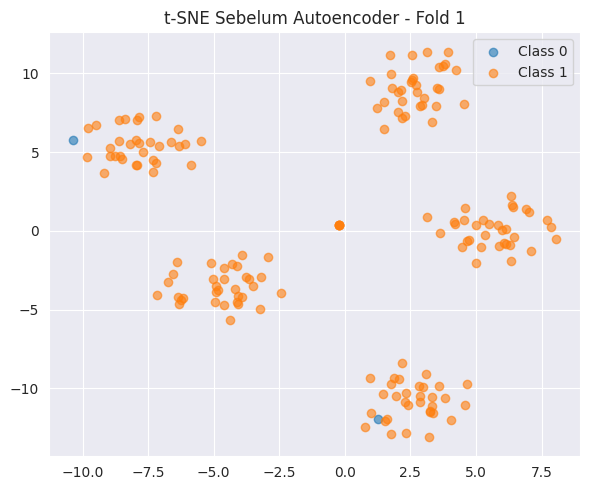

Epoch 1/70


2025-05-19 07:23:23.374691: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5434 - val_loss: 822026112.0000 - learning_rate: 0.0010
Epoch 2/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4921 - val_loss: 822026112.0000 - learning_rate: 0.0010
Epoch 3/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4921 - val_loss: 822026112.0000 - learning_rate: 0.0010
Epoch 4/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4921 - val_loss: 822026112.0000 - learning_rate: 0.0010
Epoch 5/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4921 - val_loss: 822026112.0000 - learning_rate: 0.0010
Epoch 6/70
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4914
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4921 - val_loss: 822026112.0000 - learning_rate: 0.0010
Epoch 7/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4921 - val_loss: 822026112.0000 - learning_rate: 5.0000e-04
Epoch 8/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4921

2025-05-19 07:23:31.398597: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


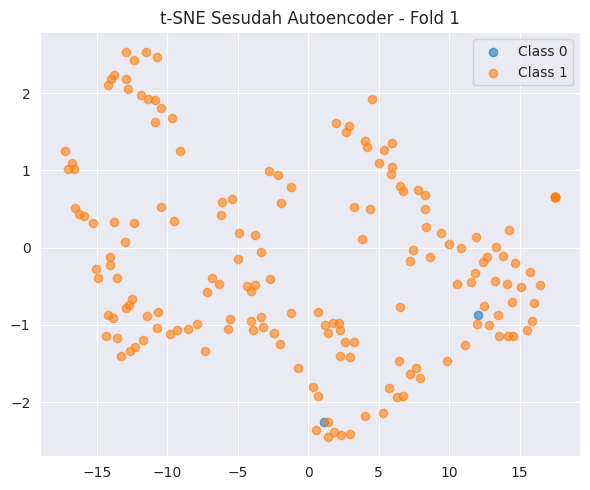

Latent shape: (170, 640)
latent_stacking : (170, 121)

=== y_cond (10 dimensi - Feature Importance Aggregated) ===
Production               : 0.0523
Importation              : 0.0070
Demand                   : 0.0121
Supply                   : 0.0146
Price                    : 0.0091
Jumlah Penduduk          : 0.0006
HBKN                     : 0.0115
Latitude                 : 0.0345
Longitude                : 0.0089
Economy Growth (%)       : 0.0338
latent_avg               : 0.0126


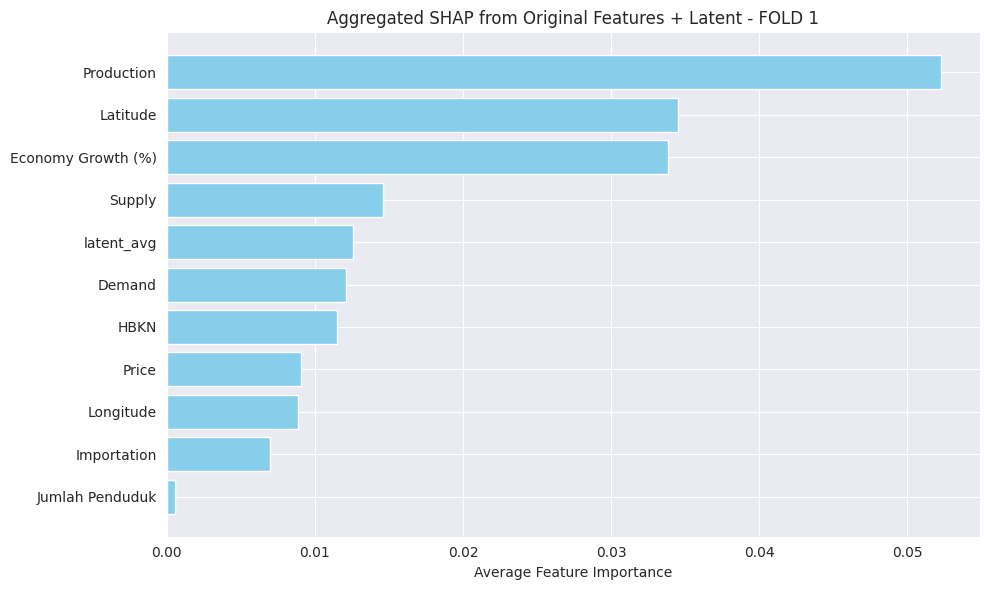


===== FOLD 2 =====


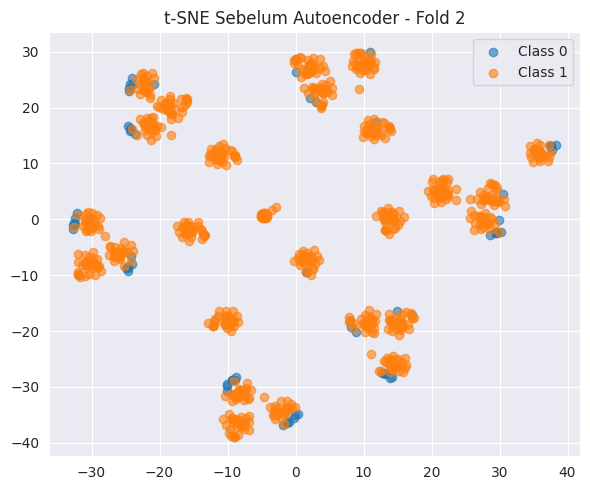

Epoch 1/70


2025-05-19 07:23:39.383453: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.5109 - val_loss: 4187267.0000 - learning_rate: 0.0010
Epoch 2/70
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4910 - val_loss: 4187267.0000 - learning_rate: 0.0010
Epoch 3/70
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4910 - val_loss: 4187267.0000 - learning_rate: 0.0010
Epoch 4/70
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4910 - val_loss: 4187267.0000 - learning_rate: 0.0010
Epoch 5/70
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4910 - val_loss: 4187267.0000 - learning_rate: 0.0010
Epoch 6/70
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4910
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4910 - val_loss: 4187267.0000 - learning_rate: 0.0010
Epoch 7/70
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4910 - val_loss: 4187267.0000 - learning_rate: 5.0000e-04
Epoch 8/70
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4

2025-05-19 07:23:57.914347: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


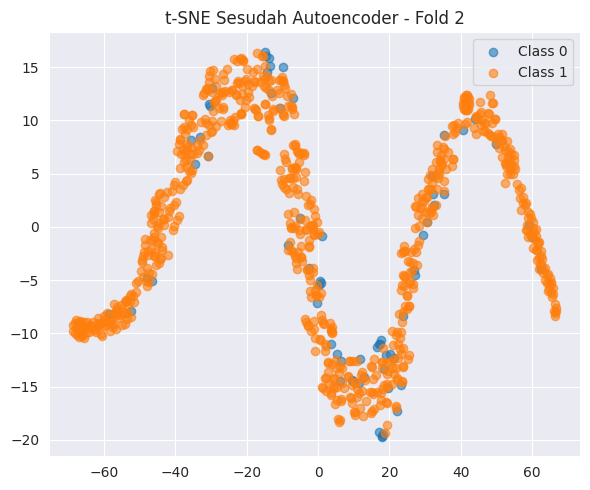

Latent shape: (850, 640)
latent_stacking : (850, 121)

=== y_cond (10 dimensi - Feature Importance Aggregated) ===
Production               : 0.1394
Importation              : 0.0159
Demand                   : 0.0149
Supply                   : 0.0193
Price                    : 0.0234
Jumlah Penduduk          : 0.0012
HBKN                     : 0.0072
Latitude                 : 0.0281
Longitude                : 0.0151
Economy Growth (%)       : 0.0400
latent_avg               : 0.0809


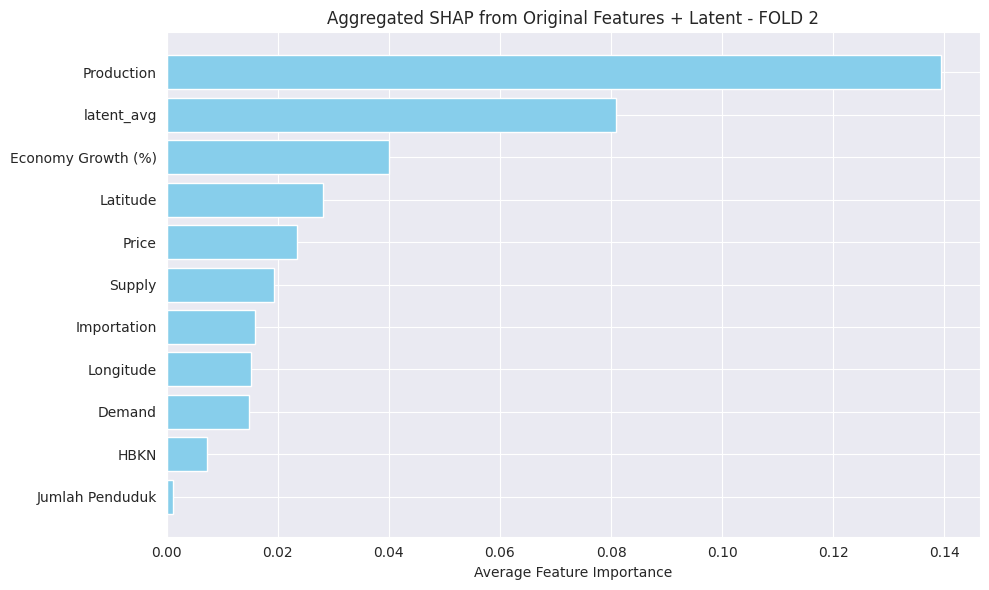


===== FOLD 3 =====


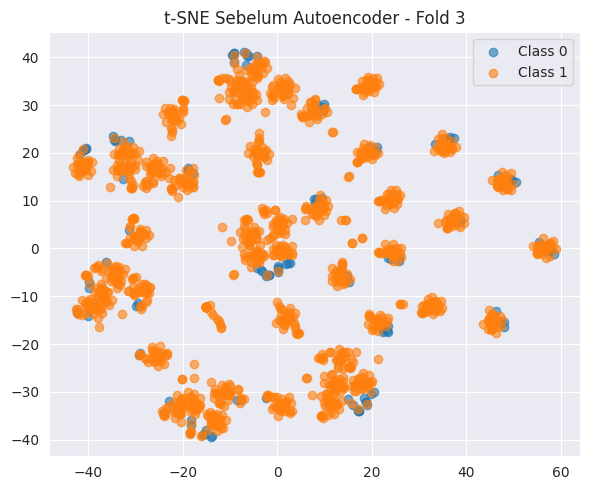

Epoch 1/70


2025-05-19 07:24:09.804435: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


379/383 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5484

2025-05-19 07:24:15.353542: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.5482 - val_loss: 650699.7500 - learning_rate: 0.0010
Epoch 2/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5402 - val_loss: 650699.7500 - learning_rate: 0.0010
Epoch 3/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5402 - val_loss: 650699.7500 - learning_rate: 0.0010
Epoch 4/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5402 - val_loss: 650699.7500 - learning_rate: 0.0010
Epoch 5/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5402 - val_loss: 650699.7500 - learning_rate: 0.0010
Epoch 6/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5402
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5402 - val_loss: 650699.7500 - learning_rate: 0.0010
Epoch 7/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5402 - val_loss: 650699.7500 - learning_rate: 5.0000e-04
Epoch 8/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5402 - v

2025-05-19 07:24:39.446049: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


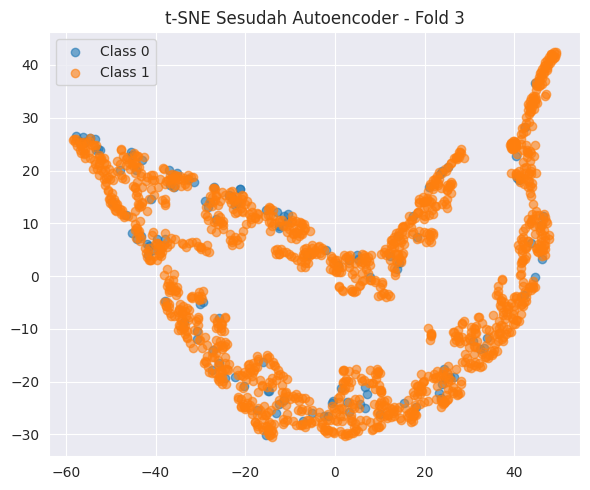

Latent shape: (1530, 640)
latent_stacking : (1530, 121)

=== y_cond (10 dimensi - Feature Importance Aggregated) ===
Production               : 0.1680
Importation              : 0.0174
Demand                   : 0.0262
Supply                   : 0.0302
Price                    : 0.0268
Jumlah Penduduk          : 0.0018
HBKN                     : 0.0060
Latitude                 : 0.0249
Longitude                : 0.0192
Economy Growth (%)       : 0.0382
latent_avg               : 0.1476


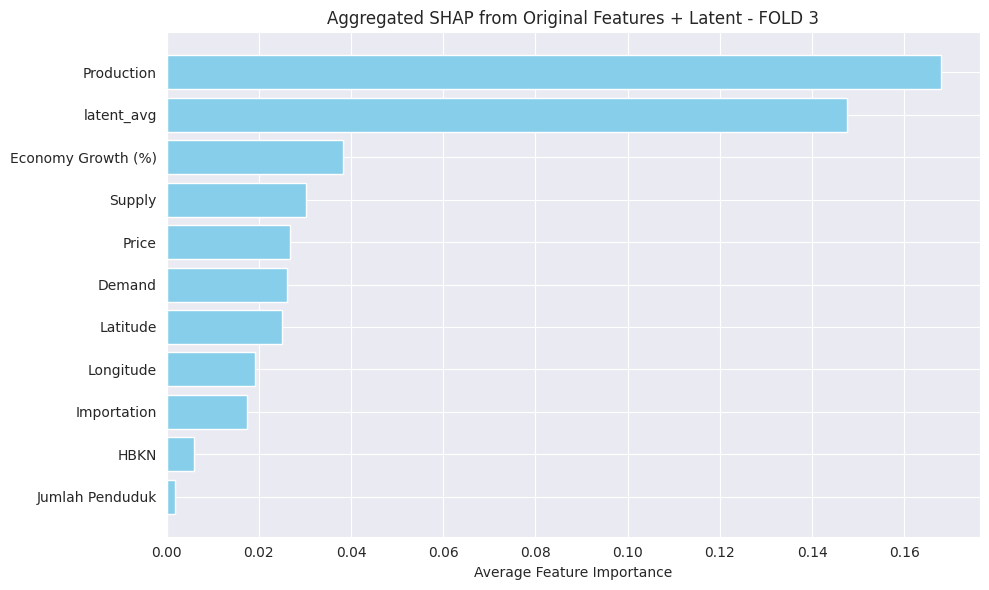


===== FOLD 4 =====


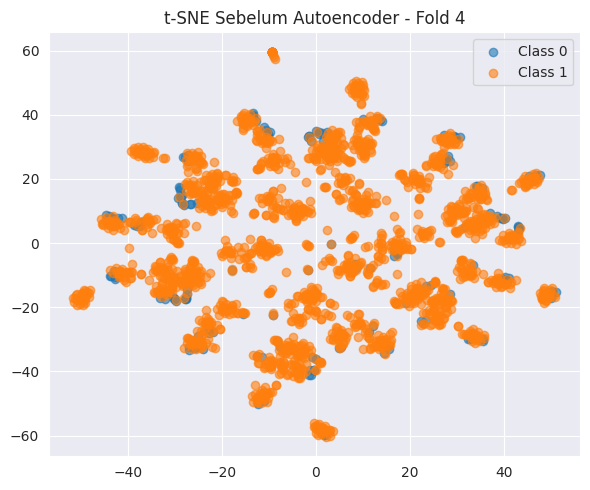

Epoch 1/70


2025-05-19 07:25:02.802153: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


550/553 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5628

2025-05-19 07:25:11.182550: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


553/553 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.5627 - val_loss: 1120806.3750 - learning_rate: 0.0010
Epoch 2/70
553/553 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5549 - val_loss: 1120806.3750 - learning_rate: 0.0010
Epoch 3/70
553/553 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5549 - val_loss: 1120806.3750 - learning_rate: 0.0010
Epoch 4/70
553/553 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.5549 - val_loss: 1120806.3750 - learning_rate: 0.0010
Epoch 5/70
553/553 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5549 - val_loss: 1120806.3750 - learning_rate: 0.0010
Epoch 6/70
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5549
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
553/553 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5549 - val_loss: 1120806.3750 - learning_rate: 0.0010
Epoch 7/70
553/553 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5549 - val_loss: 1120806.3750 - learning_rate: 5.0000e-04
Epoch 8/70
553/553 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5

2025-05-19 07:25:45.750415: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


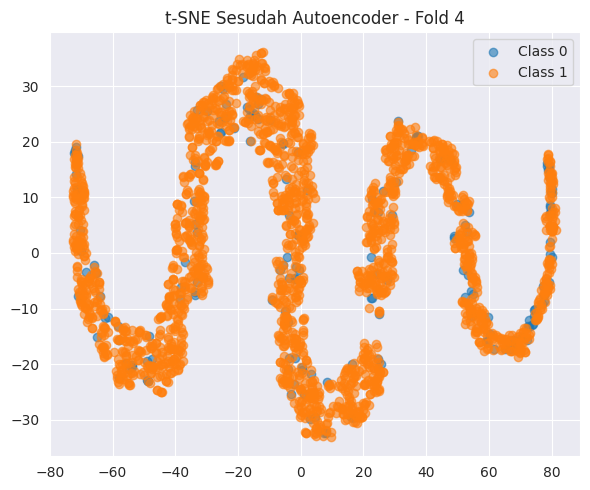

Latent shape: (2210, 640)
latent_stacking : (2210, 121)

=== y_cond (10 dimensi - Feature Importance Aggregated) ===
Production               : 0.1822
Importation              : 0.0213
Demand                   : 0.0312
Supply                   : 0.0379
Price                    : 0.0278
Jumlah Penduduk          : 0.0018
HBKN                     : 0.0058
Latitude                 : 0.0243
Longitude                : 0.0208
Economy Growth (%)       : 0.0400
latent_avg               : 0.1697


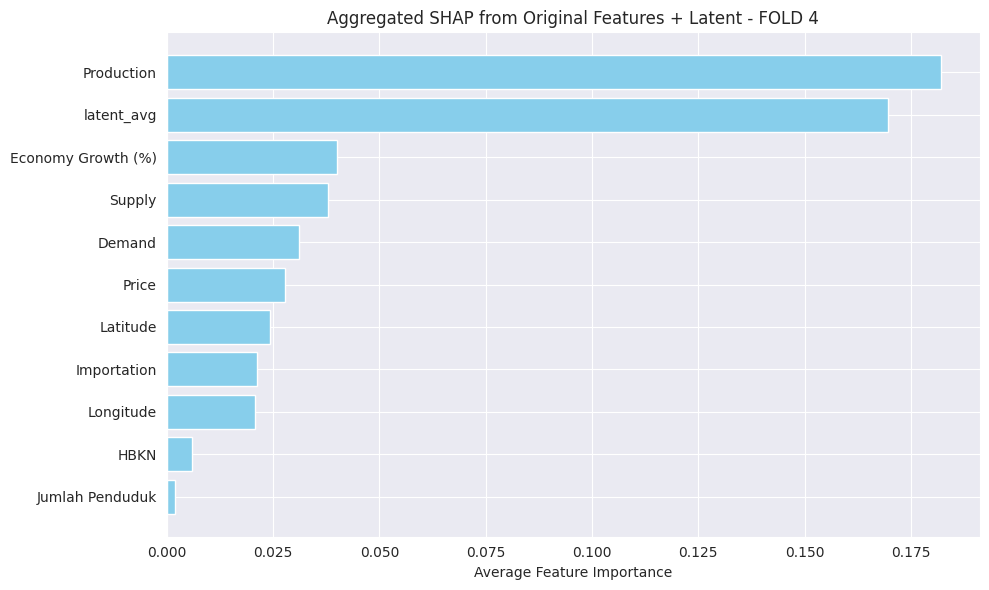


===== FOLD 5 =====


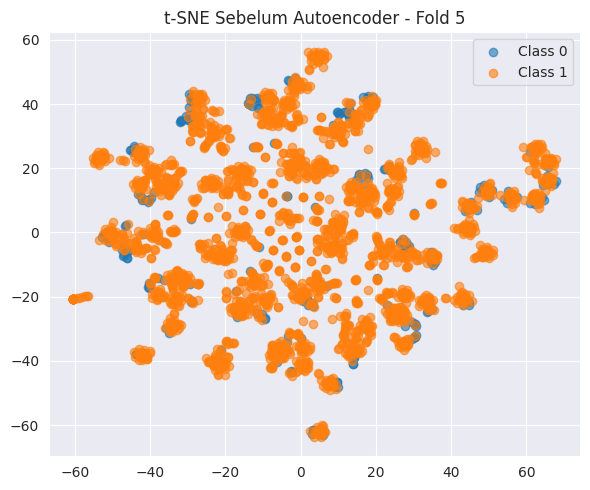

Epoch 1/70


2025-05-19 07:26:15.418493: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


722/723 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5624

2025-05-19 07:26:23.183580: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


723/723 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.5624 - val_loss: 74.2351 - learning_rate: 0.0010
Epoch 2/70
723/723 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5576 - val_loss: 74.2351 - learning_rate: 0.0010
Epoch 3/70
723/723 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5576 - val_loss: 74.2351 - learning_rate: 0.0010
Epoch 4/70
723/723 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5576 - val_loss: 74.2351 - learning_rate: 0.0010
Epoch 5/70
723/723 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5576 - val_loss: 74.2351 - learning_rate: 0.0010
Epoch 6/70
721/723 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5576
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
723/723 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5576 - val_loss: 74.2351 - learning_rate: 0.0010
Epoch 7/70
723/723 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5576 - val_loss: 74.2351 - learning_rate: 5.0000e-04
Epoch 8/70
723/723 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5576 - val_loss: 74.2351 - learning_

2025-05-19 07:27:07.477561: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


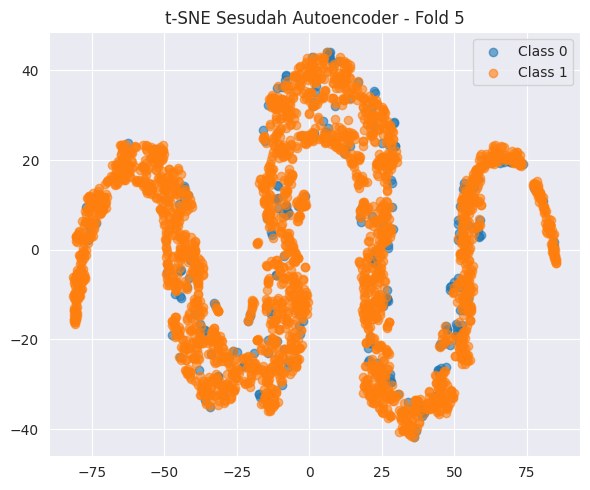

Latent shape: (2890, 640)
latent_stacking : (2890, 121)

=== y_cond (10 dimensi - Feature Importance Aggregated) ===
Production               : 0.1936
Importation              : 0.0209
Demand                   : 0.0378
Supply                   : 0.0400
Price                    : 0.0297
Jumlah Penduduk          : 0.0017
HBKN                     : 0.0065
Latitude                 : 0.0242
Longitude                : 0.0257
Economy Growth (%)       : 0.0361
latent_avg               : 0.1690


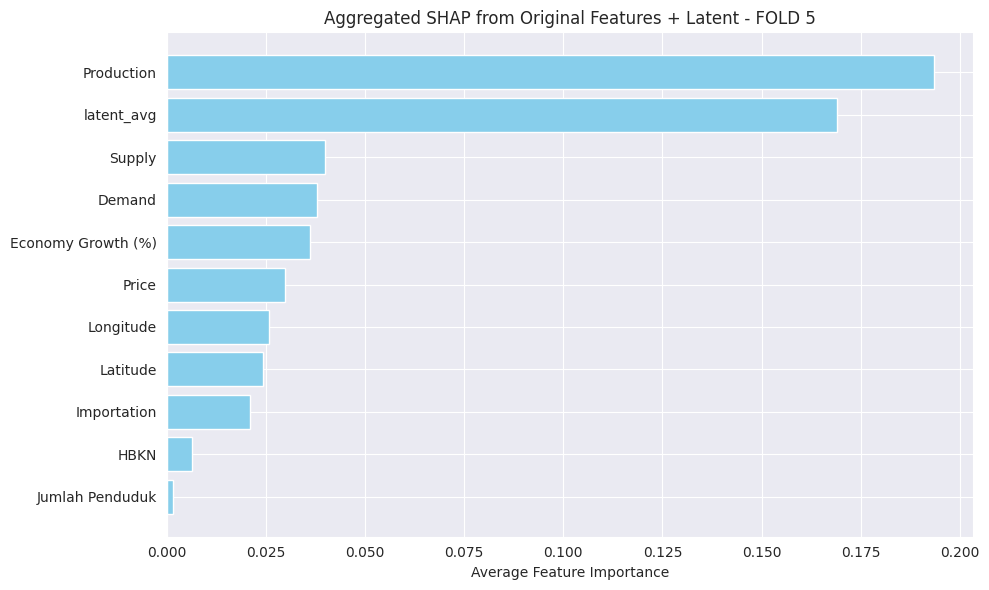

Evaluasi untuk Fold ke-1:
              precision    recall  f1-score   support

           0       1.00      0.05      0.09        21
           1       0.97      1.00      0.99       659

    accuracy                           0.97       680
   macro avg       0.99      0.52      0.54       680
weighted avg       0.97      0.97      0.96       680

Evaluasi untuk Fold ke-2:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        95
           1       0.96      0.96      0.96       585

    accuracy                           0.93       680
   macro avg       0.86      0.85      0.85       680
weighted avg       0.93      0.93      0.93       680

Evaluasi untuk Fold ke-3:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        58
           1       0.97      0.98      0.98       622

    accuracy                           0.96       680
   macro avg       0.87      0.85      0.86       

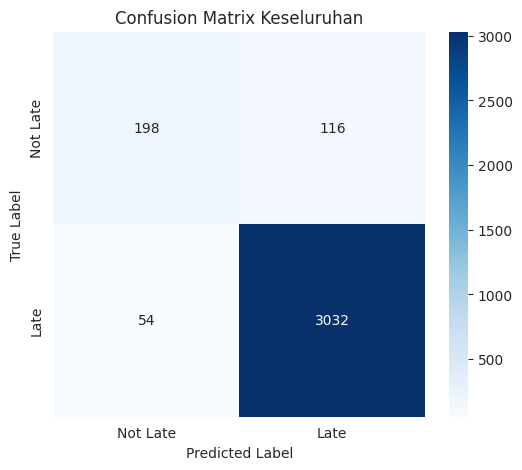


DataFrame per Fold:
             Fold 1    Fold 2    Fold 3    Fold 4    Fold 5
Accuracy   0.970588  0.930882  0.957353  0.948529  0.942647
F1 Score   0.537981  0.854297  0.860054  0.746676  0.869565
Recall     0.523810  0.849618  0.851619  0.708047  0.836045
Precision  0.985272  0.859176  0.869018  0.808385  0.915207
AUPRC      0.970545  0.953828  0.973152  0.961184  0.949002
AUROC      0.523810  0.849618  0.851619  0.708047  0.836045

DataFrame Rata-rata Keseluruhan:
               Mean
Accuracy   0.950000
F1 Score   0.773715
Recall     0.753828
Precision  0.887412
AUPRC      0.961542
AUROC      0.753828


In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.manifold import TSNE
import shap

# Nama asli fitur
feature_names_asli = [
    'Production',
    'Importation',
    'Demand',
    'Supply',
    'Price',
    'Jumlah Penduduk',
    'HBKN',
    'Latitude',
    'Longitude',
    'Economy Growth (%)'
]
all_importances = []
n_step = lookback
n_fitur_asli = 10

# Fungsi Autoencoder dan Encoder dengan conditional input
def create_conditional_autoencoder_encoder(input_shape_x, input_shape_cond, dropout_rate=0.1):
    input_x = Input(shape=input_shape_x)
    input_cond = Input(shape=input_shape_cond)

    # Gabungkan input fitur dan kondisi
    merged = Concatenate()([input_x, input_cond])

    x = Dense(1024, activation='relu')(merged)
    x = Dropout(dropout_rate)(x)
    x = Dense(896, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(768, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    encoded = Dense(640, activation='relu')(x)

    x = Dropout(dropout_rate)(encoded)
    x = Dense(768, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(896, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(1024, activation='relu')(x)
    decoded = Dense(input_shape_x[0], activation='sigmoid')(x)

    autoencoder = Model([input_x, input_cond], decoded)
    encoder = Model([input_x, input_cond], encoded)

    return autoencoder, encoder

# Fungsi contoh untuk buat sequence multi-step (harus sudah kamu punya)
def create_sequence(X, Y, lookback, step):
    Xs, Ys = [], []
    for i in range(len(X) - lookback - step + 1):
        Xs.append(X[i:(i+lookback)])
        Ys.append(Y[(i+lookback):(i+lookback+step)])
    return np.array(Xs), np.array(Ys)

# Fungsi multi_step_target untuk split data time series (sesuai kode kamu)
def multi_step_target(Xx, Yy, Yy_conditional, step, lookback, kfold):
    X_train_fold = {i:[] for i in range(kfold)}
    X_test_fold = {i:[] for i in range(kfold)}
    Y_train_fold = {i:[] for i in range(kfold)}
    Y_test_fold = {i:[] for i in range(kfold)}
    Y_cond_train_fold = {i:[] for i in range(kfold)}
    Y_cond_test_fold = {i:[] for i in range(kfold)}

    tscv = TimeSeriesSplit(n_splits=kfold)

    for name, group in Yy.groupby(level='Province'):
        dataset_X = np.array(Xx[Xx.index.get_level_values('Province') == name].reset_index(drop=True))
        dataset_Y = np.array(Yy[Yy.index.get_level_values('Province') == name].reset_index(drop=True))
        dataset_Ycond = np.array(Yy_conditional[Yy_conditional.index.get_level_values('Province') == name].reset_index(drop=True))

        for fold, (train_idx, test_idx) in enumerate(tscv.split(dataset_X)):
            # Split fitur
            X_train, X_test = dataset_X[train_idx], dataset_X[test_idx]

            # Split target
            y_train, y_test = dataset_Y[train_idx], dataset_Y[test_idx]
            y_cond_train, y_cond_test = dataset_Ycond[train_idx], dataset_Ycond[test_idx]

            # Standarisasi fitur
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Buat urutan multi-step
            X_seq_train, Y_seq_train = create_sequence(X_train_scaled, y_train, lookback, step)
            X_seq_test, Y_seq_test = create_sequence(X_test_scaled, y_test, lookback, step)

            _, Y_cond_seq_train = create_sequence(X_train_scaled, y_cond_train, lookback, step)
            _, Y_cond_seq_test = create_sequence(X_test_scaled, y_cond_test, lookback, step)

            # Simpan
            X_train_fold[fold].append(X_seq_train)
            Y_train_fold[fold].append(Y_seq_train)
            X_test_fold[fold].append(X_seq_test)
            Y_test_fold[fold].append(Y_seq_test)
            Y_cond_train_fold[fold].append(Y_cond_seq_train)
            Y_cond_test_fold[fold].append(Y_cond_seq_test)

    # Gabungkan hasil antar-provinsi dalam setiap fold
    for i in range(kfold):
        X_train_fold[i] = np.concatenate(X_train_fold[i], axis=0)
        X_test_fold[i] = np.concatenate(X_test_fold[i], axis=0)
        Y_train_fold[i] = np.concatenate(Y_train_fold[i], axis=0)
        Y_test_fold[i] = np.concatenate(Y_test_fold[i], axis=0)
        Y_cond_train_fold[i] = np.concatenate(Y_cond_train_fold[i], axis=0)
        Y_cond_test_fold[i] = np.concatenate(Y_cond_test_fold[i], axis=0)

    return X_train_fold, X_test_fold, Y_train_fold, Y_test_fold, Y_cond_train_fold, Y_cond_test_fold

# Contoh pemanggilan fungsi multi_step_target (sesuaikan variabel data, step, lookback, kfold)
Xx = data.drop(columns=['Target', 'y_conditional'])
Yy = data['Target']
Yy_conditional = data['y_conditional']

X_train_fold, X_test_fold, Y_train_fold, Y_test_fold, Y_cond_train_fold, Y_cond_test_fold = multi_step_target(
    Xx, Yy, Yy_conditional,
    step=step,
    lookback=lookback,
    kfold=kfold
)

# Tempat menyimpan hasil
y_true = {}
y_preds = {}

print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

all_X_train_jadi = []
all_y_train = []

for i in range(kfold):
    print(f"\n===== FOLD {i+1} =====")

    fold_index = i
    # Ambil data fold
    X_train = X_train_fold[i]  # shape: (samples, lookback, fitur)
    X_test = X_test_fold[i]
    y_train = Y_train_fold[i]
    y_test = Y_test_fold[i]
    y_cond_train = Y_cond_train_fold[i]
    y_cond_test = Y_cond_test_fold[i]

    # Flatten fitur dan conditional input
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    Y_cond_train_flat = y_cond_train.reshape(y_cond_train.shape[0], -1)
    Y_cond_test_flat = y_cond_test.reshape(y_cond_test.shape[0], -1)

    # Buat dan compile autoencoder conditional
    input_shape_x = (X_train_flat.shape[1],)
    input_shape_cond = (Y_cond_train_flat.shape[1],)


 # --- Visualisasi t-SNE sebelum Autoencoder ---
    # Warna otomatis dari colormap tab10 (maks 10 kelas)
    cmap = plt.cm.get_cmap("tab10")  # Ganti dengan "tab20" kalau jumlah kelas >10
    
    # --- Visualisasi t-SNE sebelum Autoencoder ---
    tsne_before = TSNE(n_components=2, perplexity=30, random_state=seed)
    X_train_tsne_before = tsne_before.fit_transform(X_train_flat)
    
    plt.figure(figsize=(6, 5))
    labels = np.unique(y_train[:, 0])
    for idx, label in enumerate(labels):
        plt.scatter(
            X_train_tsne_before[y_cond_train[:, 0] == label, 0],
            X_train_tsne_before[y_cond_train[:, 0] == label, 1],
            color=cmap(idx),  # warna dari colormap berdasarkan indeks
            label=f"Class {label}", alpha=0.6
        )
    plt.title(f"t-SNE Sebelum Autoencoder - Fold {i+1}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    autoencoder, encoder_model = create_conditional_autoencoder_encoder(input_shape_x, input_shape_cond)

    autoencoder.compile(optimizer=Adam(0.001), loss='mse')

    # Train autoencoder
    autoencoder.fit(
        [X_train_flat, Y_cond_train_flat], X_train_flat,
        validation_data=([X_test_flat, Y_cond_test_flat], X_test_flat),
        epochs=70,
        batch_size=4,
        verbose=1,
        callbacks=[early_stopping, Regularisasi]
    )

    # Ambil latent features dari encoder
    X_train_latent = encoder_model.predict([X_train_flat, Y_cond_train_flat])
    X_test_latent = encoder_model.predict([X_test_flat, Y_cond_test_flat])

           # --- Visualisasi t-SNE sesudah Autoencoder ---
    tsne_after = TSNE(n_components=2, perplexity=30, random_state=seed)
    X_train_tsne_after = tsne_after.fit_transform(X_train_latent)
    
    plt.figure(figsize=(6, 5))
    for idx, label in enumerate(labels):
        plt.scatter(
            X_train_tsne_after[y_cond_train[:, 0] == label, 0],
            X_train_tsne_after[y_cond_train[:, 0] == label, 1],
            color=cmap(idx),
            label=f"Class {label}", alpha=0.6
        )
    plt.title(f"t-SNE Sesudah Autoencoder - Fold {i+1}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Latent shape: {X_train_latent.shape}")

    # encoded_df = pd.DataFrame(X_train_flat, columns=[f"enc_{i}" for i in range(X_train_flat.shape[1])])
    # latent_df = pd.DataFrame(X_train_latent, columns=[f"flat_{i}" for i in range(X_train_latent.shape[1])])
    # X_train_jadi = pd.concat([encoded_df, latent_df], axis=1)
    
    # # Ulangi juga untuk X_test_encoded:
    # encoded_test_df = pd.DataFrame(X_test_flat, columns=[f"enc_{i}" for i in range(X_test_flat.shape[1])])
    # latent_test_df = pd.DataFrame(X_test_latent, columns=[f"flat_{i}" for i in range(X_test_latent.shape[1])])
    # X_test_jadi = pd.concat([encoded_test_df, latent_test_df], axis=1)
    # print(X_test_jadi)
    # print(f"latent_stacking : {X_train_jadi.shape}")

    # Ambil latent features dari encoder
    # X_train_latent = encoder_model.predict([X_train_flat, Y_cond_train_flat])  # (samples, 640)
    # X_test_latent = encoder_model.predict([X_test_flat, Y_cond_test_flat])
    
    # --- Rata-rata dari bottleneck (640) menjadi (samples, 1) ---
    X_train_latent_avg = np.mean(X_train_latent, axis=1).reshape(-1, 1)
    X_test_latent_avg = np.mean(X_test_latent, axis=1).reshape(-1, 1)
    
    # --- Buat DataFrame flatten dan bottleneck (rata-rata) ---
    encoded_df = pd.DataFrame(X_train_flat, columns=[f"enc_{i}" for i in range(X_train_flat.shape[1])])  # 120 kolom
    latent_df = pd.DataFrame(X_train_latent_avg, columns=["latent_avg"])  # 1 kolom
    X_train_jadi = pd.concat([encoded_df, latent_df], axis=1)  # shape: (samples, 121)
    
    encoded_test_df = pd.DataFrame(X_test_flat, columns=[f"enc_{i}" for i in range(X_test_flat.shape[1])])
    latent_test_df = pd.DataFrame(X_test_latent_avg, columns=["latent_avg"])
    X_test_jadi = pd.concat([encoded_test_df, latent_test_df], axis=1)
    
    print(f"latent_stacking : {X_train_jadi.shape}")

    # === Voting Classifier ===
    xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
    catboost = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=5, verbose=0, random_seed=seed)
    voting_clf = VotingClassifier(estimators=[('xgb', xgb), ('catboost', catboost)], voting='hard', n_jobs=-1)
    hybrid_model = MultiOutputClassifier(voting_clf)
    hybrid_model.fit(X_train_jadi, y_train)

    # Simpan data dari semua fold untuk SHAP analysis nanti
    all_X_train_jadi.append(X_train_jadi)
    all_y_train.append(pd.DataFrame(y_train[:, 0], columns=["target"]))


    # Prediksi
    y_pred = hybrid_model.predict(X_test_jadi)
    y_true[i] = y_test
    y_preds[i] = y_pred

# Ambil VotingClassifier terlatih    
    # Ambil VotingClassifier terlatih
    # import shap
    
    # Ambil VotingClassifier terlatih
    fitted_voting = hybrid_model.estimators_[0]
    
    # Ambil dua model dari VotingClassifier
    xgb_model = fitted_voting.named_estimators_['xgb']
    catboost_model = fitted_voting.named_estimators_['catboost']
    
    # === SHAP dari XGBoost ===
    explainer_xgb = shap.TreeExplainer(xgb_model)
    shap_values_xgb = explainer_xgb.shap_values(X_train_jadi)
    shap_importance_xgb = np.abs(shap_values_xgb).mean(axis=0)
    
    # === SHAP dari CatBoost ===
    explainer_cat = shap.TreeExplainer(catboost_model)
    shap_values_cat = explainer_cat.shap_values(X_train_jadi)
    shap_importance_cat = np.abs(shap_values_cat).mean(axis=0)
    
    # === Gabungkan rata-rata SHAP dari keduanya ===
    shap_importance_combined = (shap_importance_xgb + shap_importance_cat) / 2
    
    # Simpan
    all_importances.append(shap_importance_combined)



    # === Agregasi dan pembentukan y_cond ===
    mean_importance = np.mean(all_importances, axis=0)  # shape (121,)
    mean_importance_fitur_asli = mean_importance[:-1]  # buang latent_avg (terakhir)
    mean_importance_latent = mean_importance[-1]       # hanya latent_avg
    
    mean_importance_reshaped = mean_importance_fitur_asli.reshape(n_step, n_fitur_asli)
    mean_importance_by_feature = mean_importance_reshaped.mean(axis=0)

    
    # Simpan hasil sebagai y_cond (untuk Conditional Autoencoder)
    y_cond = mean_importance_by_feature  
    
    print("\n=== y_cond (10 dimensi - Feature Importance Aggregated) ===")
    for i, (f_name, imp) in enumerate(zip(feature_names_asli, y_cond)):
        print(f"{f_name:<25}: {imp:.4f}")
    print(f"{'latent_avg':<25}: {mean_importance_latent:.4f}")

    # Gabungkan fitur + latent
    sorted_features = np.array(feature_names_asli + ["latent_avg"])
    sorted_importance = np.append(y_cond, mean_importance_latent)
    
    # Urutkan
    sorted_idx = np.argsort(sorted_importance)[::-1]
    sorted_features = sorted_features[sorted_idx]
    sorted_importance = sorted_importance[sorted_idx]
    
    # Visualisasi
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importance, color='skyblue')
    plt.xlabel("Average Feature Importance")
    plt.title(f"Aggregated SHAP from Original Features + Latent - FOLD {fold_index+1}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# Evaluasi model
best_f1, y_true_best, y_pred_best, df_ae_cond5 = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)


In [197]:
# x = Dense(2048, activation='relu')(inputs)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1536, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1280, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     encoded = Dense(768, activation='relu', name="encoded_layer")(x)

#     # Decoder
#     x = Dropout(dropout_rate)(encoded)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1280, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1536, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(2048, activation='relu')(x)
#     decoded = Dense(input_shape[0], activation='sigmoid')(x)

In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.ensemble import VotingClassifier
# from sklearn.multioutput import MultiOutputClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
# from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.callbacks import EarlyStopping

# # Fungsi Autoencoder dan Encoder dengan conditional input
# def create_conditional_autoencoder_encoder(input_shape_x, input_shape_cond, dropout_rate=0.1):
#     input_x = Input(shape=input_shape_x)
#     input_cond = Input(shape=input_shape_cond)

#     # Gabungkan input fitur dan kondisi
#     merged = Concatenate()([input_x, input_cond])

#     x = Dense(2048, activation='relu')(merged)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1536, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1280, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     encoded = Dense(768, activation='relu')(x)

#     x = Dropout(dropout_rate)(encoded)
#     x = Dense(896, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1280, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(1536, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     x = Dense(2048, activation='relu')(x)
#     decoded = Dense(input_shape_x[0], activation='sigmoid')(x)

#     autoencoder = Model([input_x, input_cond], decoded)
#     encoder = Model([input_x, input_cond], encoded)

#     return autoencoder, encoder

# # Fungsi contoh untuk buat sequence multi-step (harus sudah kamu punya)
# def create_sequence(X, Y, lookback, step):
#     Xs, Ys = [], []
#     for i in range(len(X) - lookback - step + 1):
#         Xs.append(X[i:(i+lookback)])
#         Ys.append(Y[(i+lookback):(i+lookback+step)])
#     return np.array(Xs), np.array(Ys)

# # Fungsi multi_step_target untuk split data time series (sesuai kode kamu)
# def multi_step_target(Xx, Yy, Yy_conditional, step, lookback, kfold):
#     X_train_fold = {i:[] for i in range(kfold)}
#     X_test_fold = {i:[] for i in range(kfold)}
#     Y_train_fold = {i:[] for i in range(kfold)}
#     Y_test_fold = {i:[] for i in range(kfold)}
#     Y_cond_train_fold = {i:[] for i in range(kfold)}
#     Y_cond_test_fold = {i:[] for i in range(kfold)}

#     tscv = TimeSeriesSplit(n_splits=kfold)

#     for name, group in Yy.groupby(level='Province'):
#         dataset_X = np.array(Xx[Xx.index.get_level_values('Province') == name].reset_index(drop=True))
#         dataset_Y = np.array(Yy[Yy.index.get_level_values('Province') == name].reset_index(drop=True))
#         dataset_Ycond = np.array(Yy_conditional[Yy_conditional.index.get_level_values('Province') == name].reset_index(drop=True))

#         for fold, (train_idx, test_idx) in enumerate(tscv.split(dataset_X)):
#             # Split fitur
#             X_train, X_test = dataset_X[train_idx], dataset_X[test_idx]

#             # Split target
#             y_train, y_test = dataset_Y[train_idx], dataset_Y[test_idx]
#             y_cond_train, y_cond_test = dataset_Ycond[train_idx], dataset_Ycond[test_idx]

#             # Standarisasi fitur
#             scaler = StandardScaler()
#             X_train_scaled = scaler.fit_transform(X_train)
#             X_test_scaled = scaler.transform(X_test)

#             # Buat urutan multi-step
#             X_seq_train, Y_seq_train = create_sequence(X_train_scaled, y_train, lookback, step)
#             X_seq_test, Y_seq_test = create_sequence(X_test_scaled, y_test, lookback, step)

#             _, Y_cond_seq_train = create_sequence(X_train_scaled, y_cond_train, lookback, step)
#             _, Y_cond_seq_test = create_sequence(X_test_scaled, y_cond_test, lookback, step)

#             # Simpan
#             X_train_fold[fold].append(X_seq_train)
#             Y_train_fold[fold].append(Y_seq_train)
#             X_test_fold[fold].append(X_seq_test)
#             Y_test_fold[fold].append(Y_seq_test)
#             Y_cond_train_fold[fold].append(Y_cond_seq_train)
#             Y_cond_test_fold[fold].append(Y_cond_seq_test)

#     # Gabungkan hasil antar-provinsi dalam setiap fold
#     for i in range(kfold):
#         X_train_fold[i] = np.concatenate(X_train_fold[i], axis=0)
#         X_test_fold[i] = np.concatenate(X_test_fold[i], axis=0)
#         Y_train_fold[i] = np.concatenate(Y_train_fold[i], axis=0)
#         Y_test_fold[i] = np.concatenate(Y_test_fold[i], axis=0)
#         Y_cond_train_fold[i] = np.concatenate(Y_cond_train_fold[i], axis=0)
#         Y_cond_test_fold[i] = np.concatenate(Y_cond_test_fold[i], axis=0)

#     return X_train_fold, X_test_fold, Y_train_fold, Y_test_fold, Y_cond_train_fold, Y_cond_test_fold

# # Contoh pemanggilan fungsi multi_step_target (sesuaikan variabel data, step, lookback, kfold)
# Xx = data.drop(columns=['Target', 'y_conditional'])
# Yy = data['Target']
# Yy_conditional = data['y_conditional']

# X_train_fold, X_test_fold, Y_train_fold, Y_test_fold, Y_cond_train_fold, Y_cond_test_fold = multi_step_target(
#     Xx, Yy, Yy_conditional,
#     step=step,
#     lookback=lookback,
#     kfold=kfold
# )

# # Tempat menyimpan hasil
# y_true = {}
# y_preds = {}

# print('='*10, 'FORWARD CHAINING CROSS VALIDATION','='*10)

# for i in range(kfold):
#     print(f"\n===== FOLD {i+1} =====")

#     # Ambil data fold
#     X_train = X_train_fold[i]  # shape: (samples, lookback, fitur)
#     X_test = X_test_fold[i]
#     y_train = Y_train_fold[i]
#     y_test = Y_test_fold[i]
#     y_cond_train = Y_cond_train_fold[i]
#     y_cond_test = Y_cond_test_fold[i]

#     # Flatten fitur dan conditional input
#     X_train_flat = X_train.reshape(X_train.shape[0], -1)
#     X_test_flat = X_test.reshape(X_test.shape[0], -1)
#     Y_cond_train_flat = y_cond_train.reshape(y_cond_train.shape[0], -1)
#     Y_cond_test_flat = y_cond_test.reshape(y_cond_test.shape[0], -1)

#     # Buat dan compile autoencoder conditional
#     input_shape_x = (X_train_flat.shape[1],)
#     input_shape_cond = (Y_cond_train_flat.shape[1],)

#     autoencoder, encoder_model = create_conditional_autoencoder_encoder(input_shape_x, input_shape_cond)

#     autoencoder.compile(optimizer=Adam(0.001), loss='mse')

#     # Train autoencoder
#     autoencoder.fit(
#         [X_train_flat, Y_cond_train_flat], X_train_flat,
#         validation_data=([X_test_flat, Y_cond_test_flat], X_test_flat),
#         epochs=70,
#         batch_size=4,
#         verbose=1,
#         callbacks=[early_stopping, Regularisasi]
#     )

#     # Ambil latent features dari encoder
#     X_train_latent = encoder_model.predict([X_train_flat, Y_cond_train_flat])
#     X_test_latent = encoder_model.predict([X_test_flat, Y_cond_test_flat])

#     print(f"Latent shape: {X_train_latent.shape}")

#     encoded_df = pd.DataFrame(X_train_flat, columns=[f"enc_{i}" for i in range(X_train_flat.shape[1])])
#     latent_df = pd.DataFrame(X_train_latent, columns=[f"flat_{i}" for i in range(X_train_latent.shape[1])])
#     X_train_jadi = pd.concat([encoded_df, latent_df], axis=1)
    
#     # Ulangi juga untuk X_test_encoded:
#     encoded_test_df = pd.DataFrame(X_test_flat, columns=[f"enc_{i}" for i in range(X_test_flat.shape[1])])
#     latent_test_df = pd.DataFrame(X_test_latent, columns=[f"flat_{i}" for i in range(X_test_latent.shape[1])])
#     X_test_jadi = pd.concat([encoded_test_df, latent_test_df], axis=1)

#     print(f"latent_stacking : {X_train_jadi.shape}")

#     # === Voting Classifier ===
#     xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=seed)
#     catboost = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=5, verbose=0, random_seed=seed)
#     voting_clf = VotingClassifier(estimators=[('xgb', xgb), ('catboost', catboost)], voting='hard', n_jobs=-1)
#     hybrid_model = MultiOutputClassifier(voting_clf)
#     hybrid_model.fit(X_train_jadi, y_train)

#     # Prediksi
#     y_pred = hybrid_model.predict(X_test_jadi)
#     y_true[i] = y_test
#     y_preds[i] = y_pred

# # Evaluasi model
# best_f1, y_true_best, y_pred_best, df_ae_cond5 = eval_fold(y_true, y_preds, best_f1, y_true_best, y_pred_best)



In [ ]:
df_AE = pd.concat([df_ae_basic1, df_ae_basic2, df_ae_basic3, df_ae_basic_cat, df_ae_basic_cnnlstm, df_ae_seq, df_ae_cond1, df_ae_cond2,df_ae_cond3, df_ae_cond4, df_ae_cond5],axis=1)
df_AE.columns = ['AE Basic','AE Basic - Stacking 1','AE Basic - Stacking 2','AE Basic CATBOOST', 'AE Basic CNNLSTM', 'AE SEQ2SEQ', 'AE CONDITIONAL', 'AE CONDITIONAL - STACKING 1', 'AE CONDITIONAL - STACKING 2' ,'AE CONDITIONAL - LAG', 'AE CONDITIONAL - LAG + STACKING']
print(df_AE)

In [ ]:
# Set seaborn style and color palette
sns.set(style="whitegrid")
sns.set_palette("Paired")


# Transpose agar model jadi index, lalu reset untuk melt
ae_df = df_AE.T.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
ae_df.rename(columns={'index': 'Model'}, inplace=True)

# Function to add text on bars
def add_bar_values(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.3f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 8), textcoords='offset points', fontsize=8)

# Plot ML Models
plt.figure(figsize=(11.5, 6))
ax1 = sns.barplot(data=ae_df, x='Metric', y='Value', hue='Model')
add_bar_values(ax1)
plt.title('Figure 1: Perbandingan Performa Model Autoencoders + best Classifier')
plt.ylim(0.4, 1.0)
plt.legend(title='Model', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

# # Plot DL Models
# plt.figure(figsize=(11.5, 6))
# ax2 = sns.barplot(data=hybrid_df, x='Metric', y='Value', hue='Model')
# add_bar_values(ax2)
# plt.title('Figure 2: Perbandingan Performa Model Hybrid Deep Learning + best Classifier')
# plt.ylim(0.4, 1.0)
# plt.legend(title='Model', bbox_to_anchor=(1.01, 1), loc='upper left')
# plt.tight_layout()
# plt.show()


# REKAP HASIL SEMUA PERFORMA ML / DL / TRADITIONAL / HYBRID VERSI FORECAST KESELUHRUHAN PROVINCE

# FORECASTING SETIAP PROVINCE

# VISUALISASI FOWARD CHAINING CV -- PER PROVINCE

In [ ]:
# X_flat = np.array(Xx[Xx.index.get_level_values('Province') == 'Jakarta'].reset_index(drop=True))
# tscv = TimeSeriesSplit(n_splits=kfold)

# # Plotting data
# plt.figure(figsize=(10, 6))

# # Looping untuk setiap fold
# for fold, (train_idx, test_idx) in enumerate(tscv.split(X_flat)):
#     # Plot data train (warna biru) dan data test (warna merah)
#     plt.plot(train_idx, np.ones(len(train_idx)) * (fold + 1), 'bo', label='Train' if fold == 0 else "")
#     plt.plot(test_idx, np.ones(len(test_idx)) * (fold + 1), 'ro', label='Test' if fold == 0 else "")

# # Menambahkan title, label dan legend
# plt.title('Time Series Split Visualization')
# plt.xlabel('Timestep')
# plt.ylabel('Fold Number')
# plt.yticks([1, 2, 3, 4, 5], ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'])
# plt.legend()

# # Menampilkan grid dan plot
# plt.grid(True)
# plt.show()


In [ ]:
# print(best_f1)
# provinces = data.index.get_level_values('Province').unique()
# print(len(provinces))

# for i, prov in enumerate(provinces):
#     y_true_flat = []
#     y_pred_flat = []

#     for j in range(kfold):
#         y_true = y_true_best[j].reshape(len(provinces), int(y_true_best[j].shape[0]/len(provinces)), step)
#         y_pred = y_pred_best[j].reshape(len(provinces), int(y_pred_best[j].shape[0]/len(provinces)), step)

#         y_true_flat.append(y_true[i].flatten())
#         y_pred_flat.append(y_true[i].flatten())

#     y_true_flat = np.array(y_true_flat).flatten()
#     y_pred_flat = np.array(y_pred_flat).flatten()

#     print('=' * 40)
#     print(f"Evaluasi untuk Province {prov}:")
#     print(classification_report(y_true_flat, y_pred_flat))
#     print('=' * 40)
    